In [31]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler, normalize, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, cross_validate
from collections import Counter

In [2]:
data = pd.read_pickle("./processed_files/01a_preprocessing.pkl")
data

,ARR_MIN_OF_DAY_COS,JET(YN),WINGLETS(YN),CRS_ELAPSED_TIME(MINS),DISTANCE(KM),NR_PREV_ARR_FLIGHTS(1HR),NR_ENGINES,APPROACH_SPEED(KMH),WINGSPAN(M),LENGTH(M),...,EVENT_TS,08L/26R,08R/26L,09L/27R,09R/27L,10/28,ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_DELAY_MINS
5612585,0.446798,1,1,410.0,2811.51698,0,2,251.872,34.101024,37.572696,...,0,1.0,1.0,1.0,1.0,1.0,-0.781831,0.62349,0.894635,-10
5614966,0.305184,1,0,448.0,3442.37826,2,2,261.132,34.314384,42.114216,...,0,1.0,1.0,1.0,1.0,1.0,-0.781831,0.62349,0.952293,-8
5616651,0.116537,1,0,421.0,3044.87128,2,2,261.132,34.314384,42.114216,...,0,1.0,1.0,1.0,1.0,1.0,-0.781831,0.62349,0.993186,-20
5616326,0.100522,1,0,450.0,3442.37826,2,2,264.836,38.048184,54.431184,...,0,1.0,1.0,1.0,1.0,1.0,-0.781831,0.62349,0.994935,-7
5613460,0.040266,1,0,458.0,3442.37826,2,2,261.132,34.314384,42.114216,...,0,1.0,1.0,1.0,1.0,1.0,-0.781831,0.62349,0.999189,-6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11289608,0.838671,1,1,122.0,928.58918,8,2,251.872,34.101024,37.572696,...,0,0.0,0.0,0.0,0.0,0.0,-0.781831,0.62349,-0.544639,-10
11283412,0.855781,1,0,290.0,1929.59866,8,2,261.132,34.314384,42.114216,...,0,0.0,0.0,0.0,0.0,0.0,-0.781831,0.62349,-0.517338,17
11284363,0.855781,1,0,170.0,951.11994,8,2,261.132,34.314384,42.114216,...,0,0.0,0.0,0.0,0.0,0.0,-0.781831,0.62349,-0.517338,5
11286614,0.864005,1,1,179.0,1522.43564,11,2,251.872,34.101024,37.572696,...,0,0.0,0.0,0.0,0.0,0.0,-0.781831,0.62349,-0.503484,30


[-105, -75, -45, -15, 15, 45, 75, 105, 135]


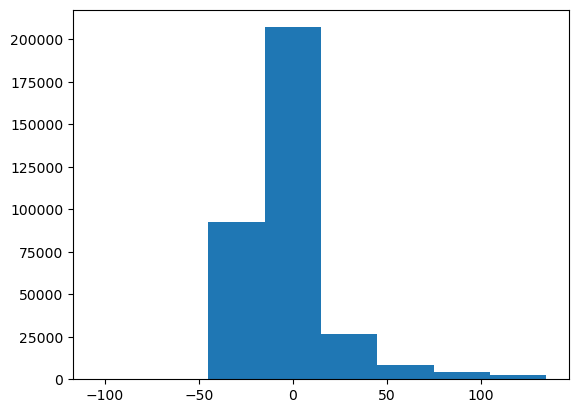

In [3]:
y = data[data.columns[-1:]].to_numpy()
X = data[data.columns[:-1]].to_numpy()
bins_pos = []

for bin_step in range(-105, 150, 30):
    bins_pos.append(bin_step)

print(bins_pos)
plt.hist(y, bins=bins_pos)
plt.show()

[]

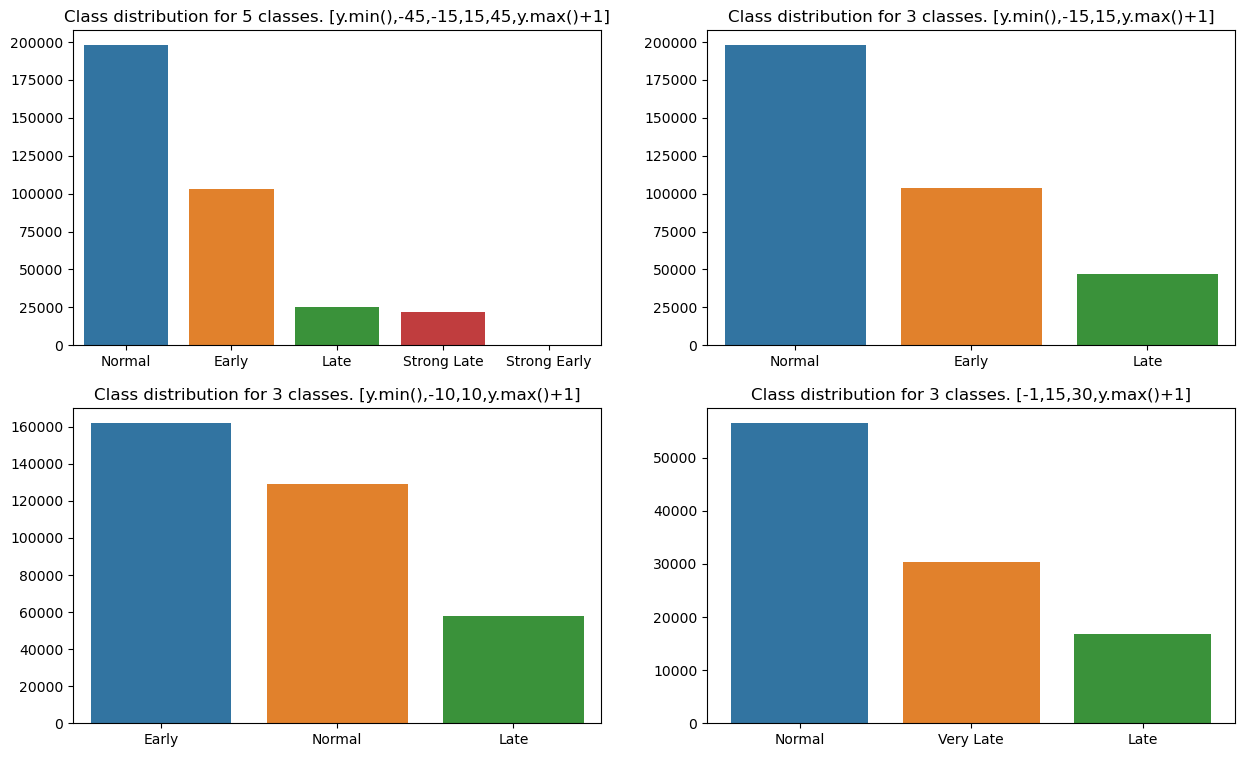

In [4]:
fig, axes = plt.subplots(2,2,figsize=(15,9))

bins1 = [y.min(),-45,-15,15,45,y.max()+1]
labels1 = ["Strong Early","Early","Normal","Late","Strong Late"]
bins2 = [y.min(),-15,15,y.max()+1]
labels2 = ["Early","Normal","Late"]
bins3 = [y.min(),-10,10,y.max()+1]
labels3 = ["Early","Normal","Late"]
bins4 = [-1,15,30,y.max()+1]
labels4 = ["Normal","Late","Very Late"]

axes[0][0].set_title("Class distribution for 5 classes. [y.min(),-45,-15,15,45,y.max()+1]")
axes[0][1].set_title("Class distribution for 3 classes. [y.min(),-15,15,y.max()+1]")
axes[1][0].set_title("Class distribution for 3 classes. [y.min(),-10,10,y.max()+1]")
axes[1][1].set_title("Class distribution for 3 classes. [-1,15,30,y.max()+1]")

data4 = data.where(data["ARR_DELAY_MINS"] >= 0).dropna()

cats1 = pd.cut(data.ARR_DELAY_MINS, bins1, labels = labels1,include_lowest = True)
cats2 = pd.cut(data.ARR_DELAY_MINS, bins2, labels = labels2,include_lowest = True)
cats3 = pd.cut(data.ARR_DELAY_MINS, bins3, labels = labels3,include_lowest = True)
cats4 = pd.cut(data4.ARR_DELAY_MINS, bins4, labels = labels4,include_lowest = True)

sns.barplot(x=list(cats1.value_counts().index), y= list(cats1.value_counts()), ax=axes[0][0])
sns.barplot(x=list(cats2.value_counts().index), y= list(cats2.value_counts()), ax=axes[0][1])
sns.barplot(x=list(cats3.value_counts().index), y= list(cats3.value_counts()), ax=axes[1][0])
sns.barplot(x=list(cats4.value_counts().index), y= list(cats4.value_counts()), ax=axes[1][1])

plt.plot()

In [5]:
SET_TO_USE = 1

if SET_TO_USE == 1:
    y_dict = {
        "Early" : 0,
        "Normal" : 1,
        "Late" : 2
    }
    data["ARR_DELAY_CATS"] = list(cats2.values)
    data = data.drop(["ARR_DELAY_MINS"], axis="columns")
    data["ARR_DELAY_CATS"] = data["ARR_DELAY_CATS"].apply(lambda x: int(y_dict.get(x)))
elif SET_TO_USE == 2:
    y_dict = {
        "Early" : 0,
        "Normal" : 1,
        "Late" : 2
    }
    data["ARR_DELAY_CATS"] = list(cats3.values)
    data = data.drop(["ARR_DELAY_MINS"], axis="columns")
    data["ARR_DELAY_CATS"] = data["ARR_DELAY_CATS"].apply(lambda x: int(y_dict.get(x)))
elif SET_TO_USE == 3:
    y_dict = {
        "Normal" : 0,
        "Late" : 1,
        "Very Late" : 1
    }
    data4["ARR_DELAY_CATS"] = list(cats4.values)
    data = data4.drop(["ARR_DELAY_MINS"], axis="columns")
    data["ARR_DELAY_CATS"] = data["ARR_DELAY_CATS"].apply(lambda x: int(y_dict.get(x)))


data

,ARR_MIN_OF_DAY_COS,JET(YN),WINGLETS(YN),CRS_ELAPSED_TIME(MINS),DISTANCE(KM),NR_PREV_ARR_FLIGHTS(1HR),NR_ENGINES,APPROACH_SPEED(KMH),WINGSPAN(M),LENGTH(M),...,EVENT_TS,08L/26R,08R/26L,09L/27R,09R/27L,10/28,ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_DELAY_CATS
5612585,0.446798,1,1,410.0,2811.51698,0,2,251.872,34.101024,37.572696,...,0,1.0,1.0,1.0,1.0,1.0,-0.781831,0.62349,0.894635,1
5614966,0.305184,1,0,448.0,3442.37826,2,2,261.132,34.314384,42.114216,...,0,1.0,1.0,1.0,1.0,1.0,-0.781831,0.62349,0.952293,1
5616651,0.116537,1,0,421.0,3044.87128,2,2,261.132,34.314384,42.114216,...,0,1.0,1.0,1.0,1.0,1.0,-0.781831,0.62349,0.993186,0
5616326,0.100522,1,0,450.0,3442.37826,2,2,264.836,38.048184,54.431184,...,0,1.0,1.0,1.0,1.0,1.0,-0.781831,0.62349,0.994935,1
5613460,0.040266,1,0,458.0,3442.37826,2,2,261.132,34.314384,42.114216,...,0,1.0,1.0,1.0,1.0,1.0,-0.781831,0.62349,0.999189,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11289608,0.838671,1,1,122.0,928.58918,8,2,251.872,34.101024,37.572696,...,0,0.0,0.0,0.0,0.0,0.0,-0.781831,0.62349,-0.544639,1
11283412,0.855781,1,0,290.0,1929.59866,8,2,261.132,34.314384,42.114216,...,0,0.0,0.0,0.0,0.0,0.0,-0.781831,0.62349,-0.517338,2
11284363,0.855781,1,0,170.0,951.11994,8,2,261.132,34.314384,42.114216,...,0,0.0,0.0,0.0,0.0,0.0,-0.781831,0.62349,-0.517338,1
11286614,0.864005,1,1,179.0,1522.43564,11,2,251.872,34.101024,37.572696,...,0,0.0,0.0,0.0,0.0,0.0,-0.781831,0.62349,-0.503484,2


In [6]:
X = data[data.columns[:-1]]
y = data[data.columns[-1:]]
#Test-Train-Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y)
print("Shape of X_train: " + str(X_train.shape))
print("Shape of y_train: " + str(y_train.shape))
print("Shape of X_test: " + str(X_test.shape))
print("Shape of y_test: " + str(y_test.shape))
X_train

Shape of X_train: (279097, 39)
Shape of y_train: (279097, 1)
Shape of X_test: (69775, 39)
Shape of y_test: (69775, 1)


,ARR_MIN_OF_DAY_COS,JET(YN),WINGLETS(YN),CRS_ELAPSED_TIME(MINS),DISTANCE(KM),NR_PREV_ARR_FLIGHTS(1HR),NR_ENGINES,APPROACH_SPEED(KMH),WINGSPAN(M),LENGTH(M),...,EVENT_SN,EVENT_TS,08L/26R,08R/26L,09L/27R,09R/27L,10/28,ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN
7876359,-0.176292,1,0,74.0,510.16078,8,3,255.576,47.335440,55.565040,...,0,0,0.0,0.0,3.0,3.0,2.0,0.000000,1.000000,0.984338
8281253,0.417745,1,1,102.0,650.17336,72,2,259.280,34.101024,44.509944,...,2,2,3.0,1.0,1.0,1.0,3.0,0.433884,-0.900969,-0.908564
11259811,0.227567,1,0,117.0,695.23488,68,2,257.428,28.446984,37.795200,...,0,0,0.0,0.0,0.0,0.0,0.0,-0.433884,-0.900969,-0.973763
6592688,-0.554733,1,0,139.0,402.33500,57,2,257.428,28.446984,37.795200,...,0,0,1.0,3.0,1.0,3.0,3.0,0.974928,-0.222521,-0.832029
8970026,0.503484,1,0,186.0,975.26004,72,2,257.428,28.446984,37.795200,...,0,0,3.0,0.0,0.0,3.0,2.0,0.433884,-0.900969,-0.864005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7577632,-0.305184,1,1,107.0,891.57436,47,2,233.352,34.101024,33.838896,...,0,0,0.0,0.0,0.0,3.0,3.0,0.974928,-0.222521,0.952293
6856848,-0.908564,1,0,298.0,2042.25246,48,3,255.576,47.335440,55.565040,...,0,0,3.0,3.0,0.0,0.0,2.0,-0.974928,-0.222521,0.417745
10388189,-0.861970,1,0,108.0,891.57436,54,3,255.576,47.335440,55.565040,...,0,0,0.0,3.0,0.0,0.0,3.0,0.974928,-0.222521,0.506960
9936124,-0.537866,1,0,171.0,975.26004,62,3,255.576,47.335440,55.565040,...,0,0,3.0,3.0,3.0,0.0,0.0,0.781831,0.623490,0.843031


In [7]:
cm = X_train.corr()
cm

,ARR_MIN_OF_DAY_COS,JET(YN),WINGLETS(YN),CRS_ELAPSED_TIME(MINS),DISTANCE(KM),NR_PREV_ARR_FLIGHTS(1HR),NR_ENGINES,APPROACH_SPEED(KMH),WINGSPAN(M),LENGTH(M),...,EVENT_SN,EVENT_TS,08L/26R,08R/26L,09L/27R,09R/27L,10/28,ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN
ARR_MIN_OF_DAY_COS,1.000000,-0.004241,-0.002267,0.154711,0.151205,-0.165048,-0.054925,0.019510,-0.001456,0.001015,...,0.183490,0.087720,-0.005347,0.001947,-0.003541,0.002875,0.007363,0.020821,0.002490,-0.373063
JET(YN),-0.004241,1.000000,0.003815,-0.020134,-0.020093,0.008066,0.004305,0.049396,0.006413,0.010476,...,0.000475,-0.002622,-0.003201,0.002029,0.001006,-0.003890,0.002144,-0.001810,0.001105,-0.003224
WINGLETS(YN),-0.002267,0.003815,1.000000,-0.102961,-0.110819,0.001400,-0.414606,-0.212678,-0.591769,-0.657829,...,0.002418,0.002846,0.005909,0.003215,-0.001234,-0.004113,-0.000813,0.001680,-0.003076,-0.003692
CRS_ELAPSED_TIME(MINS),0.154711,-0.020134,-0.102961,1.000000,0.953177,-0.137995,-0.195543,0.146362,0.041508,0.087948,...,0.041313,0.020861,-0.001451,-0.003294,-0.003803,-0.006128,-0.000510,-0.015208,-0.000172,-0.127300
DISTANCE(KM),0.151205,-0.020093,-0.110819,0.953177,1.000000,-0.154020,-0.191916,0.137329,0.083568,0.127282,...,0.035175,0.018715,0.001310,-0.002962,-0.001884,-0.003019,-0.003680,-0.020205,-0.000898,-0.109076
NR_PREV_ARR_FLIGHTS(1HR),-0.165048,0.008066,0.001400,-0.137995,-0.154020,1.000000,0.054308,-0.049155,-0.015361,-0.028003,...,0.029860,0.001239,0.042228,0.041623,0.017706,0.013169,0.036528,0.115966,-0.007235,-0.100216
NR_ENGINES,-0.054925,0.004305,-0.414606,-0.195543,-0.191916,0.054308,1.000000,-0.198073,0.821368,0.732590,...,-0.005155,-0.006053,0.003990,-0.006153,0.002242,0.002564,0.009753,0.004992,0.002642,0.017222
APPROACH_SPEED(KMH),0.019510,0.049396,-0.212678,0.146362,0.137329,-0.049155,-0.198073,1.000000,-0.098689,0.125178,...,-0.005751,-0.003962,-0.007395,-0.006156,-0.005875,-0.004077,0.000615,0.000182,-0.000900,-0.013413
WINGSPAN(M),-0.001456,0.006413,-0.591769,0.041508,0.083568,-0.015361,0.821368,-0.098689,1.000000,0.954764,...,-0.005146,-0.003966,-0.003134,-0.013414,-0.001905,0.002888,0.008461,-0.000444,0.003976,0.013056
LENGTH(M),0.001015,0.010476,-0.657829,0.087948,0.127282,-0.028003,0.732590,0.125178,0.954764,1.000000,...,-0.004993,-0.004003,-0.005045,-0.013179,-0.001901,0.002680,0.007162,-0.001619,0.003746,0.006861


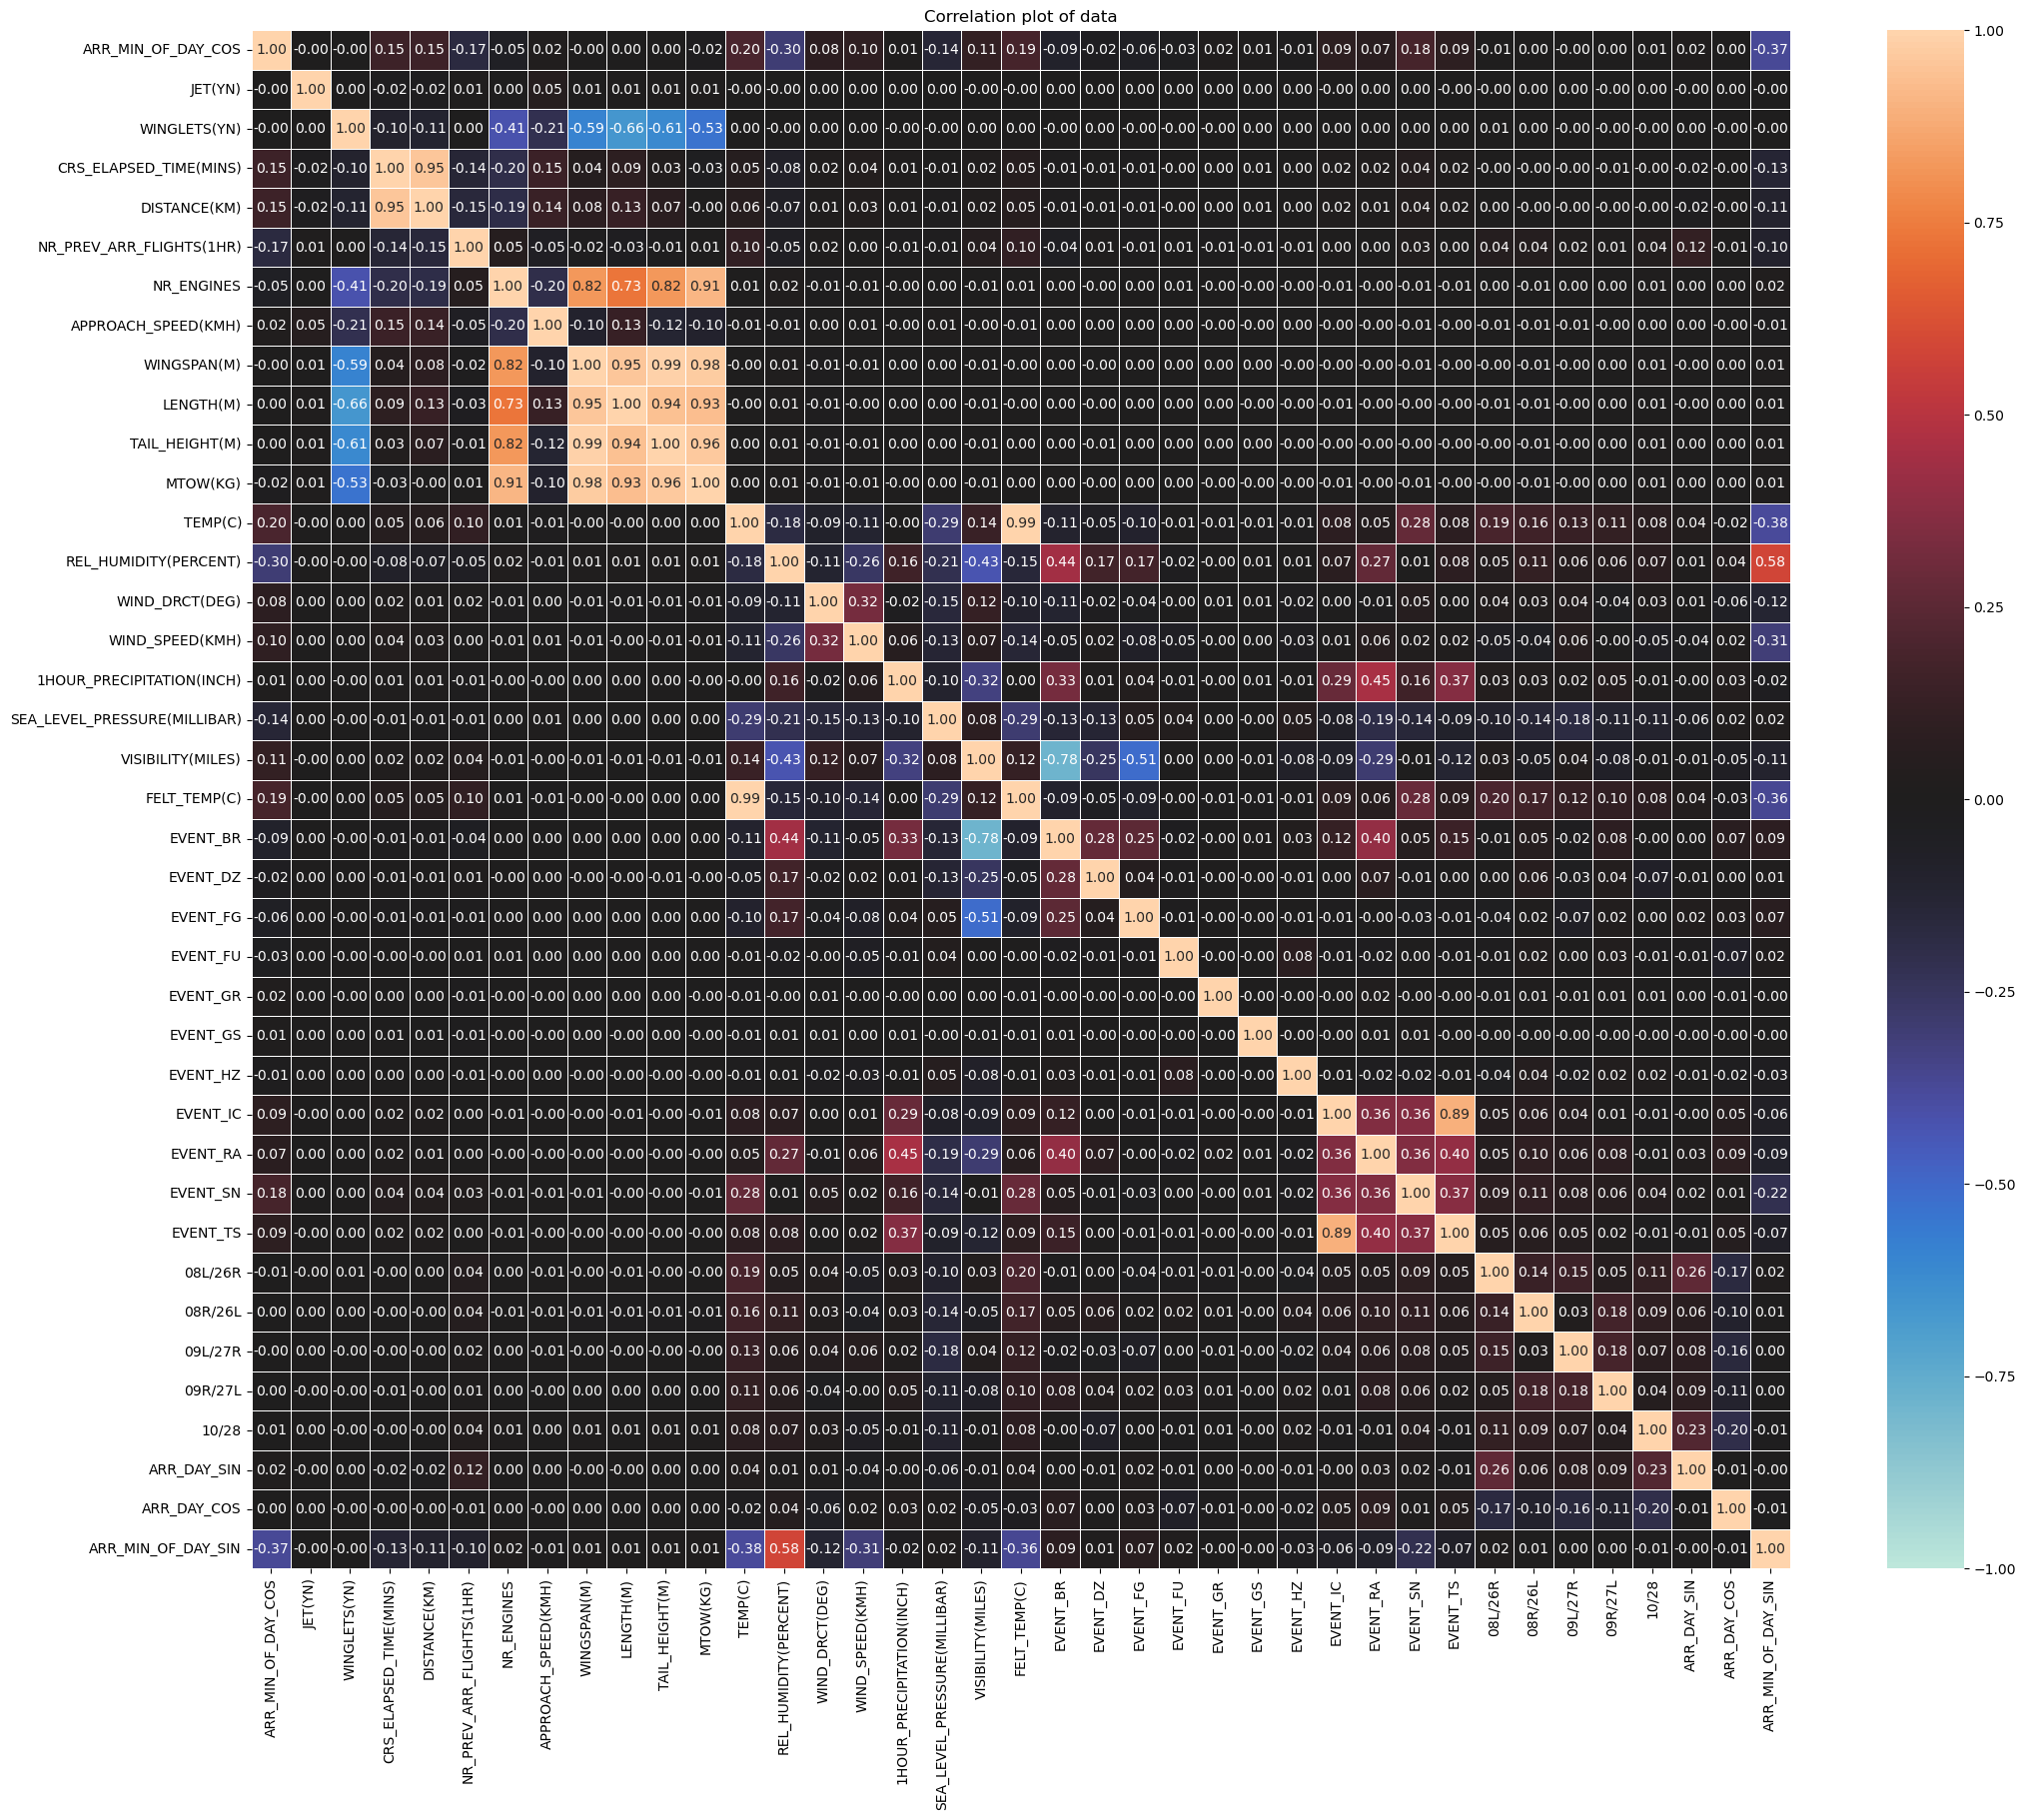

In [8]:
fig, ax = plt.subplots(figsize=(25,20))
ax.set_title("Correlation plot of data")
g = sns.heatmap(cm, center = 0, square=True, linewidths=.5, cbar=True, vmin=-1, vmax=1, annot=True, ax = ax, fmt=".2f")

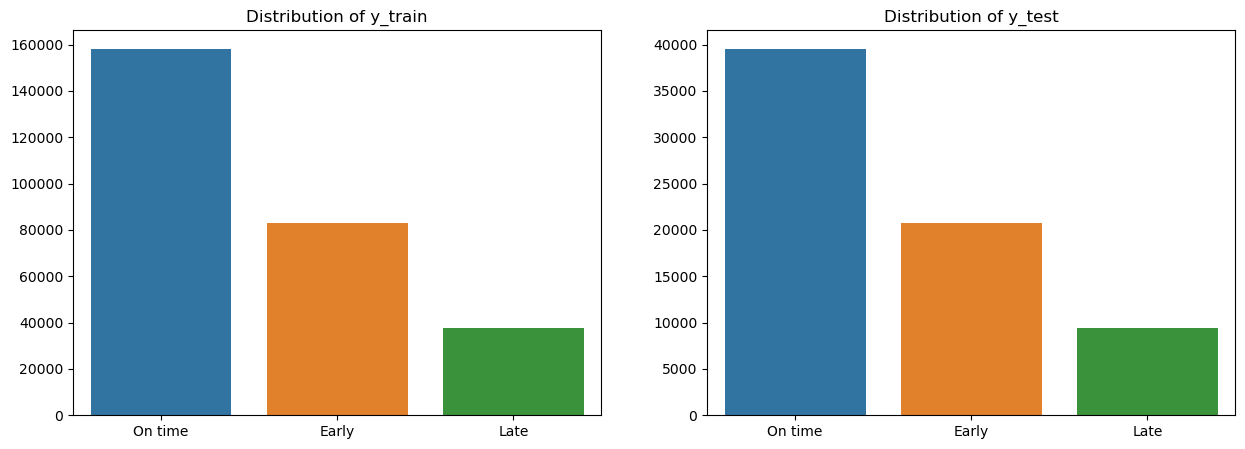

In [9]:
fig, axes = plt.subplots(1,2, sharex=True, figsize=(15,5))
axes[0].set_title("Distribution of y_train")
axes[1].set_title("Distribution of y_test")
if SET_TO_USE == 3:
    x_labels=["On time", "Late"]
else:
    x_labels=["On time", "Early", "Late"]
axes[0] = sns.barplot(x=x_labels, y=list(y_train.value_counts()), ax=axes[0])
axes[1] = sns.barplot(x=x_labels, y=list(y_test.value_counts()), ax=axes[1])

In [10]:
y_train.value_counts().index.values

array([(1,), (0,), (2,)], dtype=object)

In [11]:
scaler = MinMaxScaler().fit(X_train)
X_cols = X_train.columns
y_cols = y_train.columns
X_train = scaler.transform(X_train)
y_train = y_train.to_numpy()
X_test =scaler.transform(X_test)
y_test = y_test.to_numpy()
X_train

array([[4.11855732e-01, 1.00000000e+00, 0.00000000e+00, ...,
        5.00000000e-01, 1.00000000e+00, 9.92168968e-01],
       [7.08875424e-01, 1.00000000e+00, 1.00000000e+00, ...,
        7.22520934e-01, 5.55111512e-17, 4.57178647e-02],
       [6.13785761e-01, 1.00000000e+00, 0.00000000e+00, ...,
        2.77479066e-01, 0.00000000e+00, 1.31187340e-02],
       ...,
       [6.90154465e-02, 1.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 3.56895868e-01, 7.53479927e-01],
       [2.31068117e-01, 1.00000000e+00, 0.00000000e+00, ...,
        9.00968868e-01, 8.01937736e-01, 9.21515289e-01],
       [3.32099214e-02, 1.00000000e+00, 0.00000000e+00, ...,
        2.77479066e-01, 0.00000000e+00, 6.79183975e-01]])

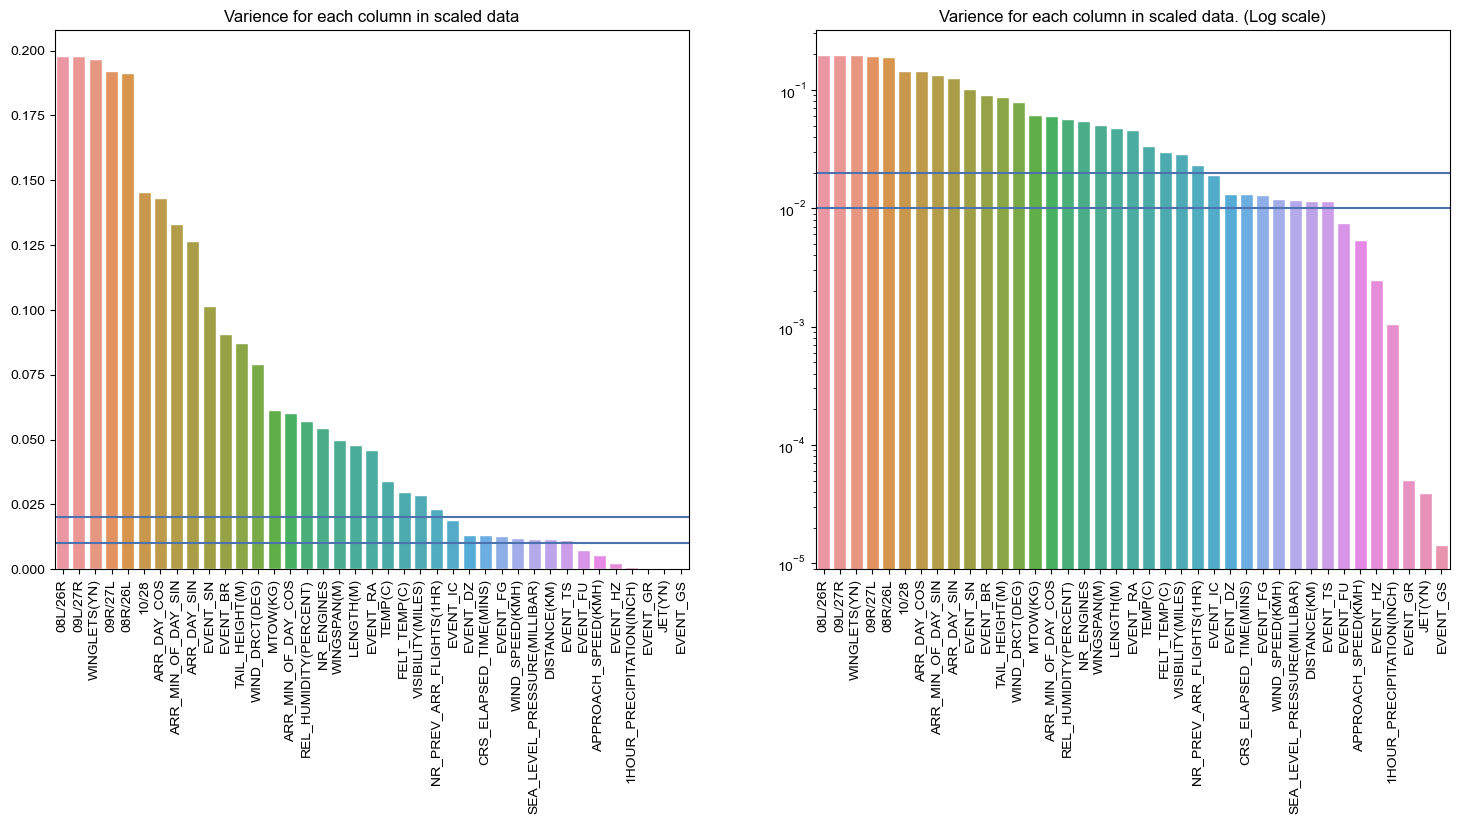

In [12]:
fig, axes = plt.subplots(1,2,figsize=(18,7))
var = pd.DataFrame(X_train, columns=X_cols).var().sort_values(ascending=False)
sns.set(style="whitegrid")
sns.barplot(x=list(var.index), y = list(var.values), ax = axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, horizontalalignment='center')
axes[0].set_title("Varience for each column in scaled data")
sns.barplot(x=list(var.index), y = list(var.values), ax = axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, horizontalalignment='center')
axes[1].set_yscale("log")
axes[1].set_title("Varience for each column in scaled data. (Log scale)")
axes[0].axhline(0.01)
axes[1].axhline(0.01)
axes[0].axhline(0.02)
axes[1].axhline(0.02)

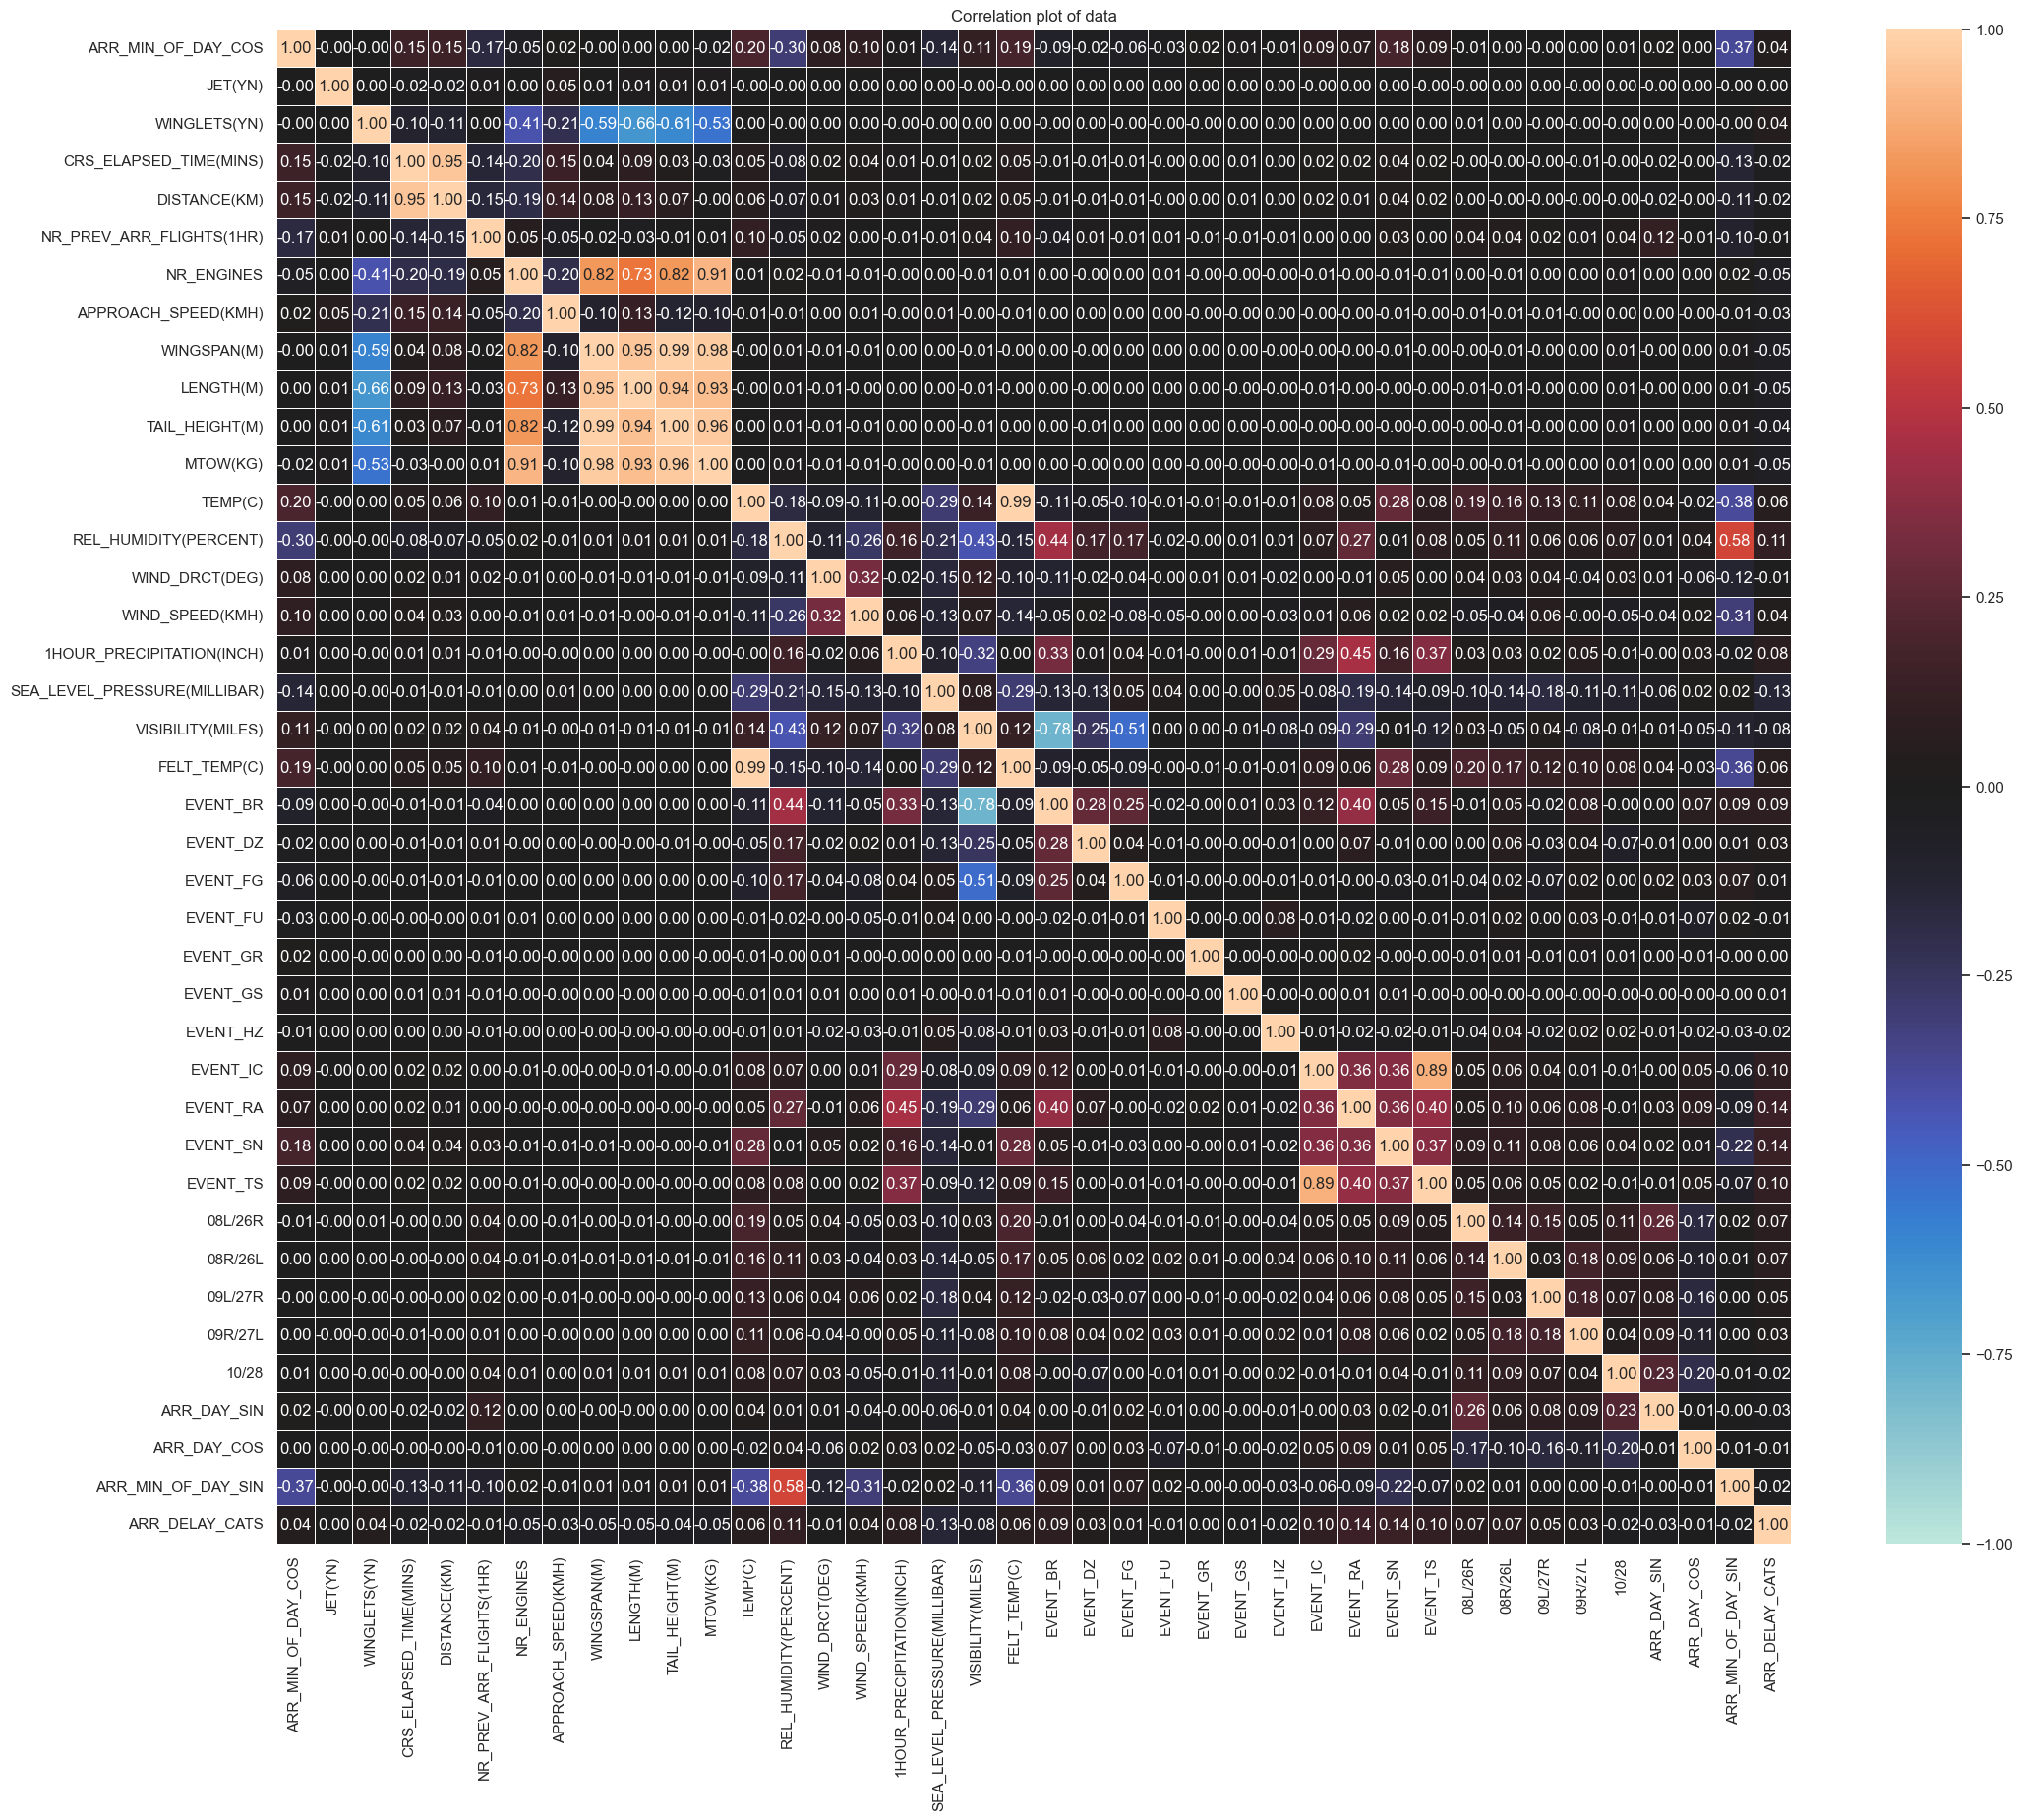

In [13]:
fig, ax = plt.subplots(figsize=(25,20))
ax.set_title("Correlation plot of data")
g = sns.heatmap(pd.DataFrame(np.hstack((X_train,y_train)), columns=list(X_cols) + list(y_cols)).corr(), center = 0, square=True, linewidths=.5, cbar=True, vmin=-1, vmax=1, annot=True, ax = ax, fmt=".2f")

In [14]:
pd.DataFrame(X_train, columns=X_cols).to_pickle("x_train.pkl")
pd.DataFrame(y_train, columns=y_cols).to_pickle("y_train.pkl")
#clf = RandomForestClassifier(n_estimators=450, max_depth=23, verbose=1, random_state=42, class_weight="balanced")
clf = RandomForestClassifier(n_estimators=250, max_depth=9, verbose=1, random_state=42, class_weight="balanced")

In [15]:
from sklearn.metrics import get_scorer
import datetime
def make_raveled(y : np.ndarray):
    if y.shape != (len(y),):
        y = y.ravel()
    return y

def mean_dict_scores(scores : dict):
    for key, val in scores.items():
        scores.update({key : val.mean()})
    return scores

def cross_val(clf, X : np.ndarray, y : np.ndarray, n_folds : int = 5, scoring = ["balanced_accuracy","f1_weighted","precision_weighted","recall_weighted"], sampler = None, n_jobs : int = 1, verbosity : int = 0):
    time_format = "%Y_%m_%d %H:%M"
    start = datetime.datetime.now()
    print("Starting cross validation at: " + start.strftime(time_format))
    make_raveled(y)
    cv = StratifiedKFold(n_splits=n_folds)
    if not sampler:
        print("Not using sampler for cross val")
        scores = cross_validate(clf, X, y, cv=cv, scoring=scoring,n_jobs=n_jobs, verbose=verbosity)
    else:
        print("Using sampler {} for cross val".format(sampler))
        scores = {}
        count = 1
        for train_fold_idx, val_fold_idx in cv.split(X,y):
            print("At step {}/{} splits.".format(count,n_folds))
            X_train, y_train = X.iloc[train_fold_idx], y[train_fold_idx]
            X_val, y_val = X.iloc[val_fold_idx], y[val_fold_idx]
            X_train, y_train = sampler.fit_resample(X_train, y_train)
            model_obj = clf.fit(X_train, y_train)
            for score in scoring:
                if(score == "balanced_accuracy"):
                    s = get_scorer(score)._score_func(y_val, model_obj.predict(X_val))
                else:
                    s = get_scorer(score)._score_func(y_val, model_obj.predict(X_val), average="weighted")
                if scores.get(score):
                   arr = scores.get(score)
                   arr.append(s)
                   scores.update({score : arr})
                else:
                   scores.update({score : [s]})
            count+=1
        for k, v in scores.items():
            scores.update({k : np.array(v)})
    end = datetime.datetime.now()
    print("Ending cross validation at: " + end.strftime(time_format))
    print("Time elapsed: " + str(end - start))
    return scores

def test_eval(clf, X_train : np.ndarray, y_train : np.ndarray, X_test : np.ndarray, y_test : np.ndarray, figsize : tuple = (10,5)):
    time_format = "%Y_%m_%d %H:%M"
    start = datetime.datetime.now()
    print("Starting model fit at: " + start.strftime(time_format))
    y_train = make_raveled(y_train)
    y_test = make_raveled(y_test)
    clf.fit(X_train, y_train)
    end = datetime.datetime.now()
    print("Ending model fit at: " + end.strftime(time_format))
    print("Time elapsed: " + str(end - start))
    fig, axes = plt.subplots(1,2, figsize=figsize)
    axes[0].grid(visible=False)
    axes[1].grid(visible=False)
    plot_confusion_matrix(clf, X_test, y_test, ax=axes[0], cmap="cividis")
    plot_confusion_matrix(clf, X_test, y_test, normalize='true', ax=axes[1], cmap="cividis")
    y_pred = clf.predict(X_test)
    plt.show()
    return y_pred

low_var_labels = list(var[var < 0.01].index)
high_corr_labels = ["DISTANCE(KM)","NR_ENGINES","WINGSPAN(M)","LENGTH(M)","TAIL_HEIGHT(M)","FELT_TEMP(C)"]

In [16]:
#Performance baseline
scores = cross_val(clf=clf, X=X_train, y=y_train.ravel(), n_jobs=4, verbosity=3)
mean_scores = mean_dict_scores(scores)
mean_scores

Starting cross validation at: 2023_01_11 12:12
Not using sampler for cross val


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  2.8min remaining:  4.3min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  4.2min finished


Ending cross validation at: 2023_01_11 12:17
Time elapsed: 0:04:13.310817


{'fit_time': 149.12378039360047,
 'score_time': 2.1113985538482667,
 'test_balanced_accuracy': 0.5150499178015328,
 'test_f1_weighted': 0.48795469023793714,
 'test_precision_weighted': 0.5683622657432078,
 'test_recall_weighted': 0.48100122928288674}

In [38]:
#test_eval(clf=clf, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, figsize=(15,5))

In [16]:
print("Dimensions with var < 0.01: \n" + str(low_var_labels))
X_train = pd.DataFrame(X_train, columns=X_cols).drop(low_var_labels, axis="columns")
X_test = pd.DataFrame(X_test, columns=X_cols).drop(low_var_labels, axis="columns")
X_cols = X_train.columns
X_train.shape

Dimensions with var < 0.01: 
['EVENT_FU', 'APPROACH_SPEED(KMH)', 'EVENT_HZ', '1HOUR_PRECIPITATION(INCH)', 'EVENT_GR', 'JET(YN)', 'EVENT_GS']


(279097, 32)

In [115]:
#Performance baseline
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
scores = cross_val(clf=clf, X=X_train, y=y_train.ravel(), n_jobs=4, verbosity=3)
mean_scores = mean_dict_scores(scores)
mean_scores

Starting cross validation at: 2022_12_19 12:21


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  3.7min finished


Ending cross validation at: 2022_12_19 12:25
Time elapsed: 0:03:43.901641


{'fit_time': 131.05649824142455,
 'score_time': 2.216798496246338,
 'test_balanced_accuracy': 0.5158838128475348,
 'test_f1_weighted': 0.48849558094858947,
 'test_precision_weighted': 0.5681743824673171,
 'test_recall_weighted': 0.4814061077369323}

In [40]:
#test_eval(clf=clf, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, figsize=(15, 5))

In [17]:
print("Dimensions with high correlation: \n" + str(high_corr_labels))
X_train_corr_filter = pd.DataFrame(X_train, columns=X_cols).drop(high_corr_labels, axis="columns")
X_test_corr_filter = pd.DataFrame(X_test, columns=X_cols).drop(high_corr_labels, axis="columns")
X_cols_corr = X_train_corr_filter.columns
X_train_corr_filter.shape

Dimensions with high correlation: 
['DISTANCE(KM)', 'NR_ENGINES', 'WINGSPAN(M)', 'LENGTH(M)', 'TAIL_HEIGHT(M)', 'FELT_TEMP(C)']


(279097, 26)

In [18]:
X_cols = X_cols_corr

In [118]:
X_train_corr_filter = X_train_corr_filter.to_numpy()
X_test_corr_filter = X_test_corr_filter.to_numpy()
scores = cross_val(clf=clf, X=X_train_corr_filter, y=y_train.ravel(), n_jobs=4, verbosity=3)
mean_dict_scores(scores)

Starting cross validation at: 2022_12_19 12:25


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.1min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  3.3min finished


Ending cross validation at: 2022_12_19 12:28
Time elapsed: 0:03:16.401259


{'fit_time': 111.4870059967041,
 'score_time': 2.07199912071228,
 'test_balanced_accuracy': 0.5118804247969033,
 'test_f1_weighted': 0.4900931499835042,
 'test_precision_weighted': 0.563455538403774,
 'test_recall_weighted': 0.483022035783634}

In [43]:
#test_eval(clf=clf, X_train=X_train_corr_filter, y_train=y_train, X_test=X_test_corr_filter, y_test=y_test, figsize=(15, 5))

In [19]:
X_train = X_train_corr_filter
X_test = X_test_corr_filter
X_cols = X_cols_corr
X_train.shape

(279097, 26)

In [20]:
var = pd.DataFrame(X_train, columns=X_cols).var().sort_values(ascending=False)
low_var_labels_01 = list(var[var < 0.01].index)
low_var_labels_02 = list(var[var < 0.02].index)
print("Dimensions with var < 0.01: \n" + str(low_var_labels_01))
print("Dimensions with var < 0.02: \n" + str(low_var_labels_02))
X_train_01 = pd.DataFrame(X_train, columns=X_cols).drop(low_var_labels_01, axis="columns")
X_test_01 = pd.DataFrame(X_test, columns=X_cols).drop(low_var_labels_01, axis="columns")
X_train_02 = pd.DataFrame(X_train, columns=X_cols).drop(low_var_labels_02, axis="columns")
X_test_02 = pd.DataFrame(X_test, columns=X_cols).drop(low_var_labels_02, axis="columns")
X_cols = X_cols
X_train.shape

Dimensions with var < 0.01: 
[]
Dimensions with var < 0.02: 
['EVENT_IC', 'EVENT_DZ', 'CRS_ELAPSED_TIME(MINS)', 'EVENT_FG', 'WIND_SPEED(KMH)', 'SEA_LEVEL_PRESSURE(MILLIBAR)', 'EVENT_TS']


(279097, 26)

In [122]:
X_train_01 = X_train_01.to_numpy()
X_test_01 = X_test_01.to_numpy()
X_train_02 = X_train_02.to_numpy()
X_test_02 = X_test_02.to_numpy()
scores_01 = cross_val(clf=clf, n_jobs=4, verbosity=3,n_folds=5, y=y_train,X=X_train_01)
scores_02 = cross_val(clf=clf, n_jobs=4, verbosity=3,n_folds=5, y=y_train,X=X_train_02)
mean_dict_scores(scores_01)

Starting cross validation at: 2022_12_19 12:28


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.1min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  3.3min finished


Ending cross validation at: 2022_12_19 12:31
Time elapsed: 0:03:15.825003
Starting cross validation at: 2022_12_19 12:31


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.6min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.7min finished


Ending cross validation at: 2022_12_19 12:34
Time elapsed: 0:02:43.690414


{'fit_time': 111.38918662071228,
 'score_time': 2.0309988498687743,
 'test_balanced_accuracy': 0.5118804247969033,
 'test_f1_weighted': 0.4900931499835042,
 'test_precision_weighted': 0.563455538403774,
 'test_recall_weighted': 0.483022035783634}

In [123]:
mean_dict_scores(scores_02)

{'fit_time': 93.04450058937073,
 'score_time': 2.1234041690826415,
 'test_balanced_accuracy': 0.5073540982680416,
 'test_f1_weighted': 0.48394224726607665,
 'test_precision_weighted': 0.5590473734249904,
 'test_recall_weighted': 0.47620720132376987}

In [124]:
#test_eval(clf=clf,y_test=y_test,X_test=X_test_01,X_train=X_train_01,y_train=y_train,figsize=(10,5))

In [125]:
#test_eval(clf=clf,y_test=y_test,X_test=X_test_02,X_train=X_train_02,y_train=y_train,figsize=(10,5))

In [21]:
var = pd.DataFrame(X_train, columns=X_cols).var().sort_values(ascending=False)
low_var_labels = list(var[var < 0.01].index)
X_train = pd.DataFrame(X_train, columns=X_cols).drop(low_var_labels, axis="columns")
X_test = pd.DataFrame(X_test, columns=X_cols).drop(low_var_labels, axis="columns")

In [22]:
from factor_analyzer.factor_analyzer import FactorAnalyzer
import seaborn as sns

def find_factors(X: pd.DataFrame, fa : FactorAnalyzer):
    fa.fit(X)
    ev, v = fa.get_eigenvalues()
    plt.scatter(range(1, X.shape[1]+1), ev)
    plt.plot(range(1, X.shape[1]+1), ev)
    plt.plot(range(1, X.shape[1]+1), np.ones(shape=(len(X.columns),)))
    plt.title('Scree Plot')
    plt.xlabel('Factors')
    plt.ylabel('Eigenvalue')
    plt.grid(True)
    plt.show()
    return ev

def perform_fa(X : pd.DataFrame, fa : FactorAnalyzer):
    fa.fit(X)
    factor_loadings = pd.DataFrame(fa.loadings_, columns=['Factor'+str(x) for x in range(1,fa.n_factors+1)], index=[X.columns])
    factor_vars = pd.DataFrame(fa.get_factor_variance(), index=["Variance", "%Var", "Cum. Var."], columns = ['Factor'+str(x) for x in range(1,fa.n_factors+1)])
    return pd.concat([factor_loadings, factor_vars], ignore_index=False, axis=0)

def plot_fa_matrix(fa : FactorAnalyzer, X : pd.DataFrame, figsize : tuple = (15,15)):
    fa.fit(X)
    factor_loadings = pd.DataFrame(fa.loadings_, columns=['Factor'+str(x) for x in range(1,fa.n_factors+1)], index=[X.columns])
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title("Factor loadings of FA")
    g = sns.heatmap(factor_loadings, center = 0, square=True, linewidths=.5, cbar=True, vmin=-1, vmax=1, annot=True, ax = ax, fmt=".2f")
    return g

def show_factor_to_column(fa : FactorAnalyzer, X : pd.DataFrame):
    fa.fit(X)
    factor_loadings = pd.DataFrame(fa.loadings_, columns=['Factor'+str(x) for x in range(1,fa.n_factors+1)], index=[X.columns])
    dic = {}
    for row in factor_loadings.iterrows():
        title = row[0][0]
        vals = row[1]
        x = list(vals).index(vals.max()) + 1
        #print(str(title) + ":" + str(x))
        dic_val = dic.get(x)
        if dic_val:
            dic_val.append(title)
            dic.update({x:dic_val})
        else:
            dic.update({x:[title]})
    arr = []
    for name in dic.keys():
        arr.append([name, dic.get(name), len(dic.get(name))])
    return pd.DataFrame(arr, columns=["Factor","Columns","Length"]).set_index("Factor").sort_index()

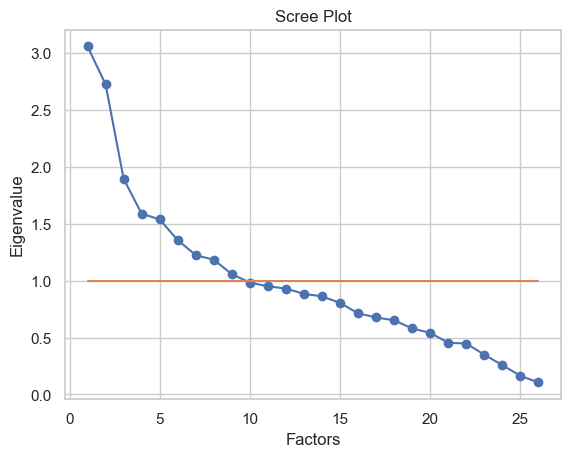

array([3.06029388, 2.72724164, 1.89610126, 1.58957776, 1.53884428,
       1.35706584, 1.22499029, 1.18447464, 1.05744194, 0.98392356,
       0.95130884, 0.93149142, 0.88440715, 0.8627457 , 0.80520815,
       0.71348281, 0.67747693, 0.65202614, 0.58041688, 0.54161138,
       0.45438766, 0.44810427, 0.34976433, 0.25777101, 0.16407713,
       0.10576511])

In [128]:
find_factors(X_train, FactorAnalyzer(rotation="Promax"))

In [129]:
fa = FactorAnalyzer(n_factors=10, rotation="Promax")
perform_fa(X_train, fa)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10
"(ARR_MIN_OF_DAY_COS,)",-0.022615,0.014079,-0.289622,0.046555,0.014676,0.136417,0.055668,-0.028027,0.043718,-0.459096
"(WINGLETS(YN),)",0.005426,-0.004483,-0.025437,0.994140,0.003964,-0.002075,-0.000064,-0.003626,-0.006102,0.084739
"(CRS_ELAPSED_TIME(MINS),)",0.010409,-0.011214,-0.073496,-0.044060,0.014085,0.007079,0.007615,0.004233,-0.011353,-0.284158
"(NR_PREV_ARR_FLIGHTS(1HR),)",-0.001731,0.004073,-0.201882,-0.037350,0.004466,-0.011008,0.050904,0.022724,0.041448,0.489687
"(MTOW(KG),)",-0.002314,0.003462,0.012082,-0.534940,-0.003823,0.000170,-0.004437,-0.001930,0.000431,0.025793
"(TEMP(C),)",-0.075653,-0.013524,-0.451488,-0.001271,-0.202940,0.554190,-0.103874,0.135836,-0.340659,0.059933
"(REL_HUMIDITY(PERCENT),)",0.166784,0.016787,0.705365,-0.014492,0.159499,0.228115,-0.002420,0.073989,-0.170932,0.001149
"(WIND_DRCT(DEG),)",-0.046892,0.038791,-0.023006,0.000988,-0.057641,0.122100,0.015967,0.064218,0.477607,-0.001641
"(WIND_SPEED(KMH),)",0.053468,-0.002927,-0.237896,-0.005581,0.066993,0.050231,0.002453,-0.057018,0.664445,0.057427
"(SEA_LEVEL_PRESSURE(MILLIBAR),)",-0.047523,-0.003769,-0.152082,0.000601,0.139869,-0.778101,0.010132,-0.100967,-0.243104,0.082118


<AxesSubplot:title={'center':'Factor loadings of FA'}, ylabel='None'>

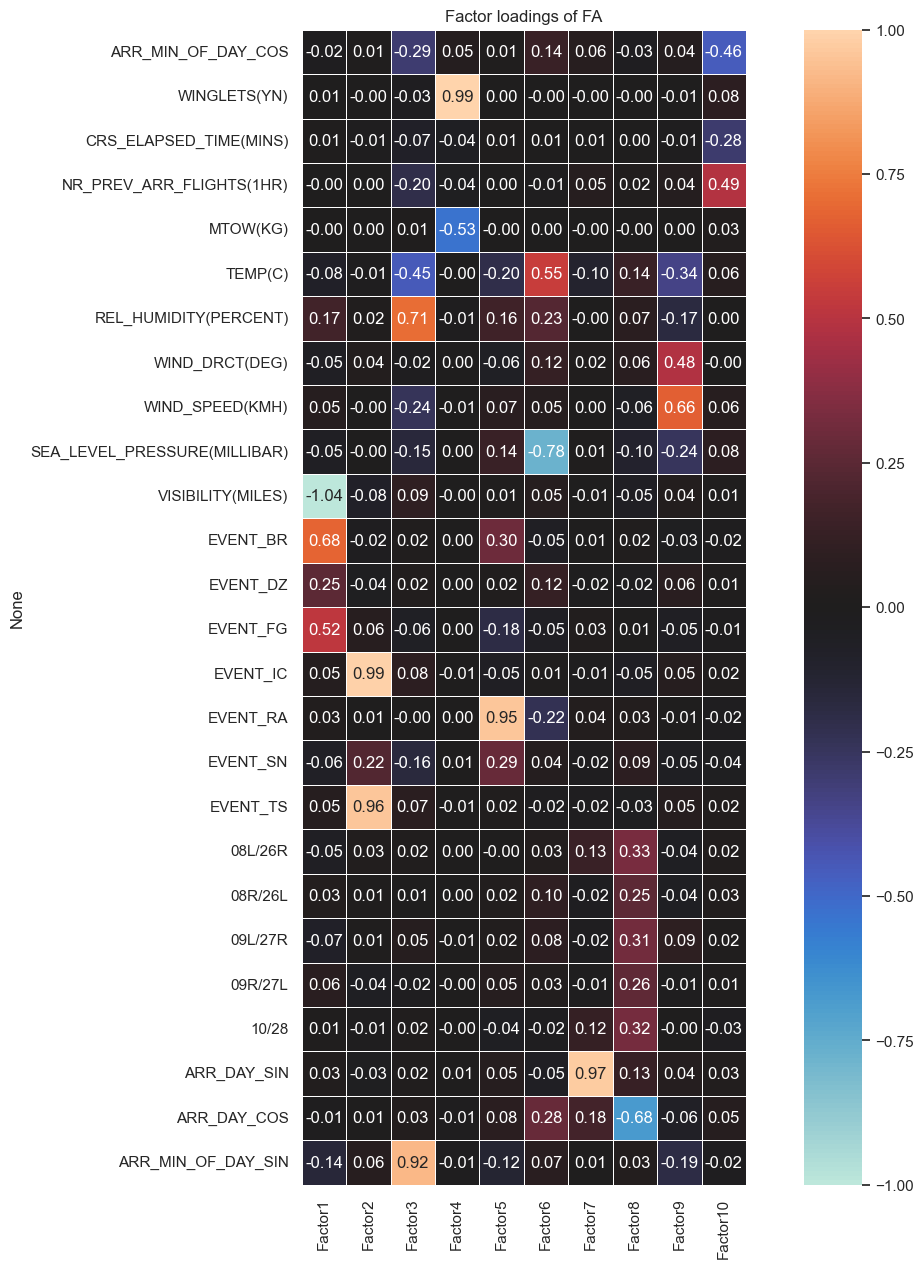

In [130]:
plot_fa_matrix(fa, X_train, (15,15))

In [131]:
show_factor_to_column(fa, X_train)

,Columns,Length
Factor,,
1,"[EVENT_BR, EVENT_DZ, EVENT_FG]",3
2,"[EVENT_IC, EVENT_TS]",2
3,"[REL_HUMIDITY(PERCENT), VISIBILITY(MILES), ARR...",3
4,[WINGLETS(YN)],1
5,"[CRS_ELAPSED_TIME(MINS), SEA_LEVEL_PRESSURE(MI...",4
6,"[ARR_MIN_OF_DAY_COS, TEMP(C), ARR_DAY_COS]",3
7,[ARR_DAY_SIN],1
8,"[08L/26R, 08R/26L, 09L/27R, 09R/27L, 10/28]",5
9,"[WIND_DRCT(DEG), WIND_SPEED(KMH)]",2


In [132]:
fa.fit(X_train)
X_latent = fa.transform(X_train)
X_latent.shape
scores = cross_val(clf, X=X_latent, y=y_train, n_jobs=4, n_folds=5, verbosity=3)
mean_dict_scores(scores)

Starting cross validation at: 2022_12_19 12:34


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  3.6min remaining:  5.4min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  6.1min finished


Ending cross validation at: 2022_12_19 12:40
Time elapsed: 0:06:08.446195


{'fit_time': 202.3140758037567,
 'score_time': 2.0062013149261473,
 'test_balanced_accuracy': 0.4992665716092242,
 'test_f1_weighted': 0.46730938943072775,
 'test_precision_weighted': 0.5536347981555696,
 'test_recall_weighted': 0.46305406507593594}

Starting model fit at: 2022_12_19 12:40


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  3.3min finished
C:\Users\chrig\anaconda3\envs\ma-env39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Ending model fit at: 2022_12_19 12:43
Time elapsed: 0:03:16.544024


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.9s finished
C:\Users\chrig\anaconda3\envs\ma-env39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.8s finished


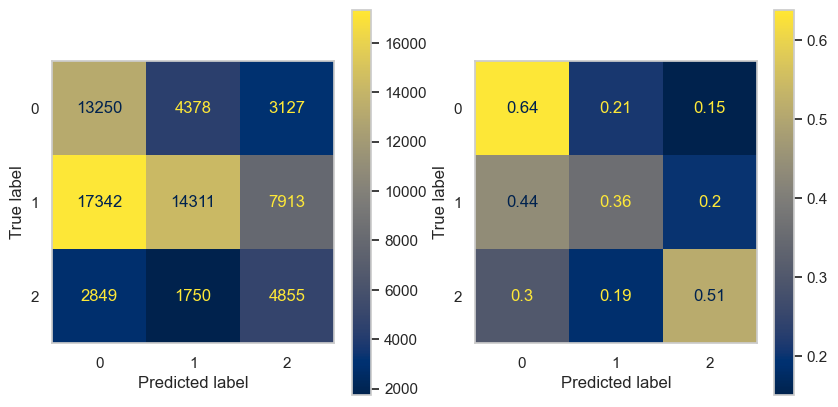

In [133]:
X_latent_test = fa.transform(X_test)
y_pred = test_eval(clf,X_train= X_latent, y_train=y_train, X_test=X_latent_test, y_test=y_test)

In [134]:
fa = FactorAnalyzer(n_factors=11, rotation="promax")
perform_fa(X_train, fa)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11
"(ARR_MIN_OF_DAY_COS,)",0.011462,-0.266607,4.620533e-02,-0.028733,0.038313,0.145235,0.053612,-0.024153,0.041621,0.002846,-0.452103
"(WINGLETS(YN),)",-0.005126,-0.023361,9.941809e-01,0.005425,0.006546,0.001598,-0.000155,-0.003486,-0.005868,0.002443,0.083638
"(CRS_ELAPSED_TIME(MINS),)",-0.007016,-0.071718,-4.388485e-02,0.007413,0.012009,0.007560,0.010888,0.005375,-0.017140,0.000632,-0.284300
"(NR_PREV_ARR_FLIGHTS(1HR),)",-0.001036,-0.187978,-3.809316e-02,-0.009759,0.018063,0.029672,0.047278,0.021650,0.040971,0.010184,0.495177
"(MTOW(KG),)",0.001743,0.012915,-5.349792e-01,-0.005490,-0.001970,0.001376,-0.005561,-0.002347,0.002070,0.001821,0.026211
"(TEMP(C),)",-0.017215,-0.367410,-1.166629e-03,-0.074281,-0.128356,0.668332,-0.107570,0.129855,-0.310100,0.024943,0.058765
"(REL_HUMIDITY(PERCENT),)",-0.037093,0.732561,-1.562611e-02,0.115189,0.213137,0.141938,-0.031988,0.050070,-0.090838,0.071523,0.010608
"(WIND_DRCT(DEG),)",-0.009015,0.014141,-1.236058e-03,-0.143708,0.007660,0.068926,-0.014471,0.047697,0.555693,0.093696,0.015320
"(WIND_SPEED(KMH),)",-0.000992,-0.246649,-4.605551e-03,0.121382,0.049533,-0.017930,0.005160,-0.050911,0.604792,-0.037570,0.052159
"(SEA_LEVEL_PRESSURE(MILLIBAR),)",-0.001862,-0.176953,6.734657e-08,-0.170075,0.106581,-0.677721,0.017118,-0.103634,-0.252481,0.026296,0.081013


,Columns,Length
Factor,,
1,"[EVENT_IC, EVENT_TS]",2
2,"[REL_HUMIDITY(PERCENT), VISIBILITY(MILES), ARR...",3
3,[WINGLETS(YN)],1
4,"[EVENT_BR, EVENT_DZ]",2
5,"[CRS_ELAPSED_TIME(MINS), SEA_LEVEL_PRESSURE(MI...",4
6,"[ARR_MIN_OF_DAY_COS, TEMP(C), ARR_DAY_COS]",3
7,[ARR_DAY_SIN],1
8,"[08L/26R, 08R/26L, 09L/27R, 09R/27L, 10/28]",5
9,"[WIND_DRCT(DEG), WIND_SPEED(KMH)]",2


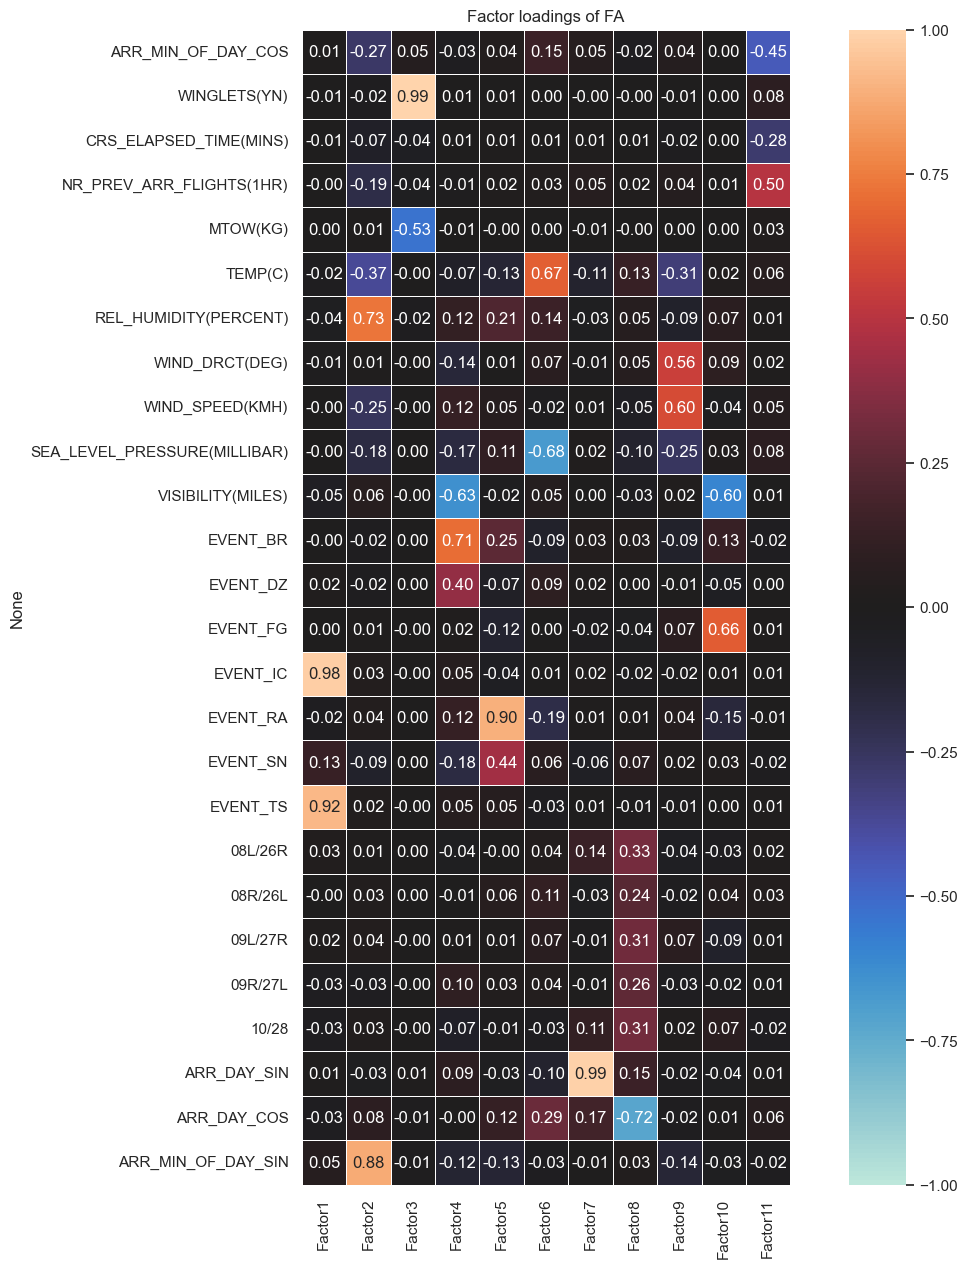

In [135]:
plot_fa_matrix(fa, X_train)
show_factor_to_column(fa, X_train)

Starting cross validation at: 2022_12_19 12:43


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  3.5min remaining:  5.3min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  6.0min finished


Ending cross validation at: 2022_12_19 12:49
Time elapsed: 0:05:58.643132
Starting model fit at: 2022_12_19 12:49


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  3.3min finished
C:\Users\chrig\anaconda3\envs\ma-env39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Ending model fit at: 2022_12_19 12:53
Time elapsed: 0:03:16.798057


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.8s finished
C:\Users\chrig\anaconda3\envs\ma-env39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.9s finished


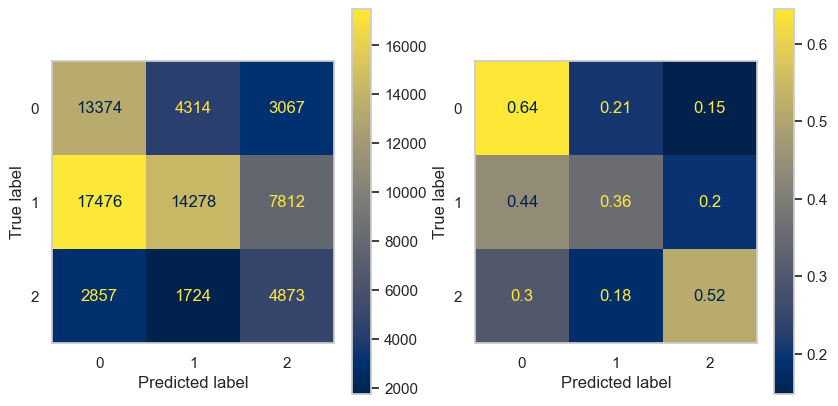

{'fit_time': 195.58102097511292,
 'score_time': 1.8436042308807372,
 'test_balanced_accuracy': 0.5023484354124259,
 'test_f1_weighted': 0.4688344581686813,
 'test_precision_weighted': 0.5558872873784308,
 'test_recall_weighted': 0.46499245767541303}

In [136]:
fa.fit(X_train)
X_latent = fa.transform(X_train)
X_latent.shape
X_latent
scores = cross_val(clf, X=X_latent, y=y_train, n_jobs=4, n_folds=5, verbosity=3)
X_latent_test = fa.transform(X_test )
y_pred = test_eval(clf,X_train= X_latent, y_train=y_train, X_test=X_latent_test, y_test=y_test)
mean_dict_scores(scores)

In [48]:
X_train = pd.DataFrame(X_train, columns=X_cols).drop(low_var_labels + high_corr_labels, axis="columns")
X_train

KeyError: "['DISTANCE(KM)', 'NR_ENGINES', 'WINGSPAN(M)', 'LENGTH(M)', 'TAIL_HEIGHT(M)', 'FELT_TEMP(C)'] not found in axis"

In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_scaled = scaler.transform(X_train)
X_scaled

array([[ 0.54878563, -0.60767064, -0.89307862, ..., -0.05571492,
         1.39092862,  1.57861637],
       [ 1.7603357 ,  1.64562831, -0.6052185 , ...,  0.56994508,
        -1.25137136, -1.01422078],
       [ 1.3724628 , -0.60767064, -0.45100773, ..., -0.68137491,
        -1.25137136, -1.10352729],
       ...,
       [-0.84966769, -0.60767064, -0.54353419, ...,  1.35013033,
        -0.30834542,  0.92471908],
       [-0.18865116, -0.60767064,  0.10415106, ...,  1.07168544,
         0.8675887 ,  1.38505805],
       [-0.99571924, -0.60767064, -0.94448221, ..., -0.68137491,
        -1.25137136,  0.72118262]])

Explained variance is [0.11770361 0.10489391]


<AxesSubplot:xlabel='Faktor 1', ylabel='Faktor 2'>

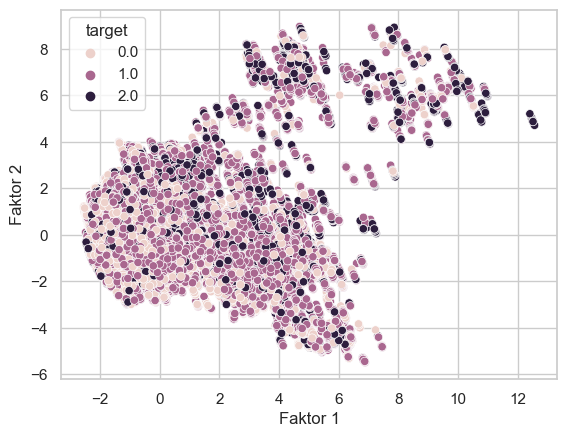

In [78]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_scaled)
print("Explained variance is {}".format(pca.explained_variance_ratio_))
X_pca_transform = pca.transform(X_scaled)
X_pca_transform_df = pd.DataFrame(np.hstack((X_pca_transform, y_train)), columns=["Faktor 1", "Faktor 2", "target"])
sns.scatterplot(data=X_pca_transform_df, x="Faktor 1", y="Faktor 2", hue="target")

In [79]:
scores = cross_val(clf=clf, n_jobs=4, verbosity=5,y=y_train,X=X_pca_transform)
mean_dict_scores(scores)

Starting cross validation at: 2022_12_20 21:48


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.7min


Ending cross validation at: 2022_12_20 21:50
Time elapsed: 0:02:34.743163


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.6min finished


{'fit_time': 91.33641748428344,
 'score_time': 3.915608549118042,
 'test_balanced_accuracy': 0.40189025964317954,
 'test_f1_weighted': 0.5013442703064013,
 'test_precision_weighted': 0.4953025918755033,
 'test_recall_weighted': 0.5263689617442114}

Explained variance is [0.11770361 0.10489391 0.07292697 0.06113761 0.05918632 0.05219484
 0.04711501 0.04555672 0.04067084 0.03784321 0.0365888  0.03582659
 0.03401566 0.03318253 0.03096954 0.02744165 0.0260568  0.02507793
 0.02232373 0.02083121 0.01747645 0.01723478 0.01345247 0.00991427
 0.00631066 0.00406789]


<AxesSubplot:>

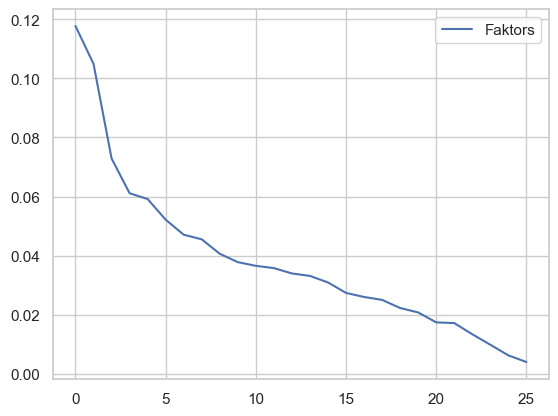

In [90]:
pca = PCA(n_components=26)
pca.fit(X_scaled)
print("Explained variance is {}".format(pca.explained_variance_ratio_))
sns.lineplot(pd.DataFrame(pca.explained_variance_ratio_, columns=["Faktors"]))

<AxesSubplot:>

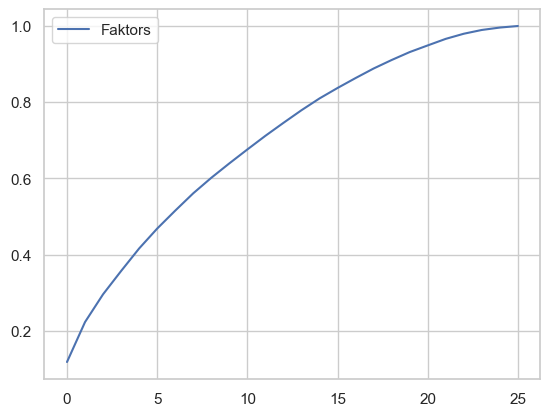

In [91]:
sns.lineplot(pd.DataFrame(pca.explained_variance_ratio_.cumsum(), columns=["Faktors"]))

In [92]:
pca = PCA(n_components=13)
pca.fit(X_scaled)
print("Explained variance is {}".format(pca.explained_variance_ratio_))
X_pca_transform = pca.transform(X_scaled)
scores = cross_val(clf=clf, n_jobs=4, verbosity=5,y=y_train,X=X_pca_transform)
mean_dict_scores(scores)

Explained variance is [0.11770361 0.10489391 0.07292697 0.06113759 0.0591863  0.05219474
 0.047115   0.04555653 0.04067084 0.03784298 0.036587   0.03582604
 0.03401442]
Starting cross validation at: 2022_12_20 22:43


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  3.3min remaining:  5.0min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  4.7min finished


Ending cross validation at: 2022_12_20 22:47
Time elapsed: 0:04:45.173055


{'fit_time': 171.84970293045043,
 'score_time': 3.7535984992980955,
 'test_balanced_accuracy': 0.45667967421195943,
 'test_f1_weighted': 0.5498413408757539,
 'test_precision_weighted': 0.5481218893461447,
 'test_recall_weighted': 0.5682576310701831}

In [96]:
arr = []
for i in range(6,22,3):
    print("At step " + str(i))
    pca = PCA(n_components=i)
    pca.fit(X_scaled)
    X_pca_transform = pca.transform(X_scaled)
    scores = cross_val(clf=clf, n_jobs=4, verbosity=5,y=y_train,X=X_pca_transform)
    mean_scores = mean_dict_scores(scores)
    _arr = [i]
    for k,v in mean_scores.items():
        _arr.append(v)
    arr.append(_arr)
arr

At step 6
Starting cross validation at: 2022_12_20 22:54


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  2.7min remaining:  4.1min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  3.7min finished


Ending cross validation at: 2022_12_20 22:57
Time elapsed: 0:03:43.842050
At step 9
Starting cross validation at: 2022_12_20 22:58


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  3.4min remaining:  5.1min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  4.7min finished


Ending cross validation at: 2022_12_20 23:02
Time elapsed: 0:04:41.312666
At step 12
Starting cross validation at: 2022_12_20 23:02


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  3.6min remaining:  5.4min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  4.9min finished


Ending cross validation at: 2022_12_20 23:07
Time elapsed: 0:04:54.328256
At step 15
Starting cross validation at: 2022_12_20 23:07


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  3.7min remaining:  5.5min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  5.1min finished


Ending cross validation at: 2022_12_20 23:12
Time elapsed: 0:05:03.852006
At step 18
Starting cross validation at: 2022_12_20 23:12


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  4.8min remaining:  7.1min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  6.5min finished


Ending cross validation at: 2022_12_20 23:19
Time elapsed: 0:06:28.176773
At step 21
Starting cross validation at: 2022_12_20 23:19


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  4.6min remaining:  6.9min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  6.5min finished


Ending cross validation at: 2022_12_20 23:25
Time elapsed: 0:06:29.709340


[[6,
  138.29797806739808,
  3.4975767135620117,
  0.44335884029761397,
  0.5413753807192172,
  0.5412797952997919,
  0.5655058998370179],
 [9,
  175.40633554458617,
  3.265713119506836,
  0.4503931778576069,
  0.5460738102923475,
  0.5453826770081938,
  0.5675410372198482],
 [12,
  184.10916166305543,
  3.519206237792969,
  0.4549847540660231,
  0.5489532708146523,
  0.5474559916125707,
  0.5681573113010393],
 [15,
  190.27858967781066,
  3.625513124465942,
  0.4567084278349191,
  0.5509302241342556,
  0.5497800974873704,
  0.5702282690208934],
 [18,
  245.93338851928712,
  3.175159788131714,
  0.4577243321394997,
  0.5512519032441491,
  0.5497757723502629,
  0.5698377305637162],
 [21,
  239.82976884841918,
  3.8087985515594482,
  0.4575334300569828,
  0.5508458859926982,
  0.5492523500788569,
  0.5693217840826816]]

In [50]:
pca_results = pd.DataFrame(arr, columns=['nr_features'] + list(mean_scores.keys()))
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
a = []
for ax in axs.reshape(-1):
    a.append(ax)
plt.ylim(0.4, 0.6)
for i,col in enumerate(pca_results.columns[3:]):
    sns.barplot(data=pca_results, x="nr_features", y=col, ax=a[i])

NameError: name 'arr' is not defined

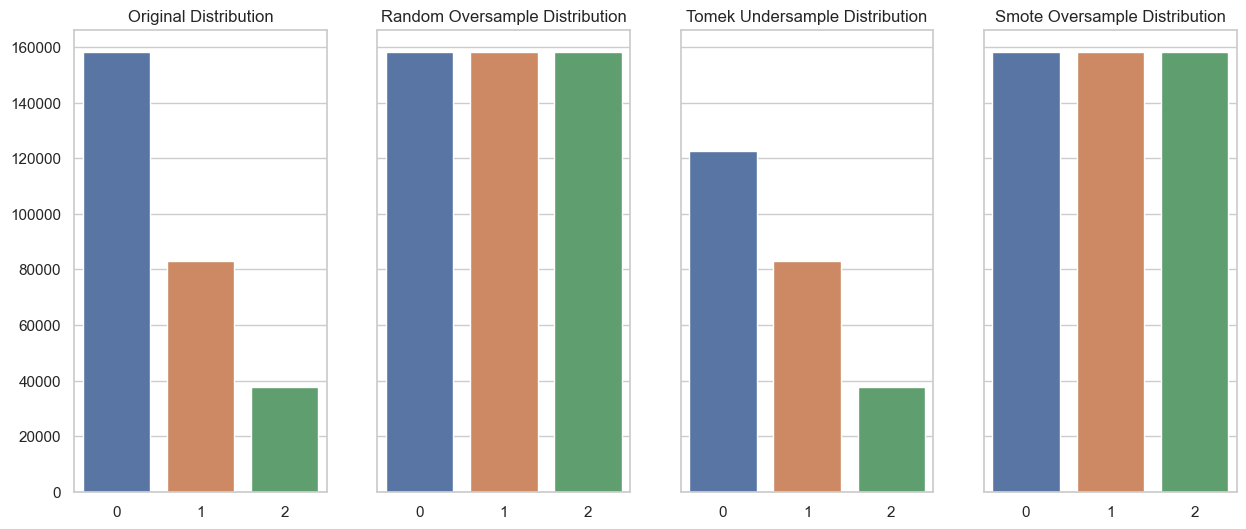

In [51]:
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

ros = RandomOverSampler(random_state=42)
smote = SMOTE()
tomek = TomekLinks(sampling_strategy='majority')
X_train_RS_smote, y_train_RS_smote = smote.fit_resample(X_train, y_train)
X_train_RS_tomek, y_train_RS_tomek = tomek.fit_resample(X_train, y_train)
X_train_RS_os, y_train_RS_os = ros.fit_resample(X_train, y_train)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,6), sharey=True)
sns.barplot(x = ["0","1","2"], y=list(pd.DataFrame(y_train).value_counts()), ax=axes[0])
sns.barplot(x = ["0","1","2"], y=list(pd.DataFrame(y_train_RS_os).value_counts()), ax=axes[1])
sns.barplot(x = ["0","1","2"], y=list(pd.DataFrame(y_train_RS_tomek).value_counts()), ax=axes[2])
sns.barplot(x = ["0","1","2"], y=list(pd.DataFrame(y_train_RS_smote).value_counts()), ax=axes[3])
axes[0].set_title("Original Distribution")
axes[1].set_title("Random Oversample Distribution")
axes[2].set_title("Tomek Undersample Distribution")
axes[3].set_title("Smote Oversample Distribution")
plt.show()

In [168]:
scores = cross_val(clf=clf, n_jobs=1, verbosity=5, y=y_train, X=X_train, sampler=ros)
mean_scores = mean_dict_scores(scores)

Starting cross validation at: 2022_12_21 01:28
Using sampler RandomOverSampler(random_state=42) for cross val
At step 1/5 splits.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      |

At step 2/5 splits.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      |

At step 3/5 splits.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      |

At step 4/5 splits.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      |

At step 5/5 splits.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      |

Ending cross validation at: 2022_12_21 01:36
Time elapsed: 0:07:56.999218


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.9s finished


In [169]:
mean_scores

{'balanced_accuracy': 0.4796750397728017,
 'f1_weighted': 0.5482275681696851,
 'precision_weighted': 0.5465215373761481,
 'recall_weighted': 0.5502352134604791}

In [170]:
scores = cross_val(clf=clf, n_jobs=1, verbosity=5, y=y_train, X=X_train, sampler=tomek)
mean_dict_scores(scores)

Starting cross validation at: 2022_12_21 01:38
Using sampler TomekLinks(sampling_strategy='majority') for cross val
At step 1/5 splits.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   29.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      |

At step 2/5 splits.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   29.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      |

At step 3/5 splits.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   29.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      |

At step 4/5 splits.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   29.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      |

At step 5/5 splits.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   27.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   28.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      |

Ending cross validation at: 2022_12_21 01:45
Time elapsed: 0:07:03.312657


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.5s finished


{'balanced_accuracy': 0.4900355401639659,
 'f1_weighted': 0.5558019359011506,
 'precision_weighted': 0.5584862237062127,
 'recall_weighted': 0.5562080544548614}

In [171]:
scores = cross_val(clf=clf, n_jobs=1, verbosity=5, y=y_train, X=X_train, sampler=smote)
mean_dict_scores(scores)

Starting cross validation at: 2022_12_21 01:45
Using sampler SMOTE() for cross val
At step 1/5 splits.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      |

At step 2/5 splits.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      |

At step 3/5 splits.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      |

At step 4/5 splits.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      |

At step 5/5 splits.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      |

Ending cross validation at: 2022_12_21 01:53
Time elapsed: 0:08:38.426849


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.8s finished


{'balanced_accuracy': 0.4879171051046495,
 'f1_weighted': 0.5523615280819746,
 'precision_weighted': 0.5517225413725402,
 'recall_weighted': 0.5530442779144592}

In [70]:
scores = cross_val(clf=clf, n_jobs=1, verbosity=5, y=y_train_RS_tomek, X=X_train_RS_tomek, sampler=smote)
mean_dict_scores(scores)

Starting cross validation at: 2023_01_04 18:05
Using sampler SMOTE() for cross val
At step 1/5 splits.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished


At step 2/5 splits.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.4s finished


At step 3/5 splits.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished


At step 4/5 splits.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.4s finished


At step 5/5 splits.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Ending cross validation at: 2023_01_04 18:16
Time elapsed: 0:10:51.240724


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.4s finished


{'balanced_accuracy': 0.521240625084578,
 'f1_weighted': 0.5206229826849308,
 'precision_weighted': 0.552791165413247,
 'recall_weighted': 0.5165543271913473}

In [74]:
from imblearn.combine import SMOTETomek

smtk = SMOTETomek(smote=smote, tomek=tomek);
scores = cross_val(clf=clf, n_jobs=1, verbosity=5, y=y_train, X=X_train, sampler=smtk)
mean_dict_scores(scores)

Starting cross validation at: 2023_01_04 19:09
Using sampler SMOTETomek(smote=SMOTE(), tomek=TomekLinks(sampling_strategy='majority')) for cross val
At step 1/5 splits.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished


At step 2/5 splits.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished


At step 3/5 splits.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished


At step 4/5 splits.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished


At step 5/5 splits.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Ending cross validation at: 2023_01_04 19:33
Time elapsed: 0:24:08.772022


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished


{'balanced_accuracy': 0.5086854281716746,
 'f1_weighted': 0.5015120007722942,
 'precision_weighted': 0.5608623721124973,
 'recall_weighted': 0.4926029244635447}

In [23]:
X_train = X_train_RS_tomek
y_train = y_train_RS_tomek
print("X_train shape: {}, y_train shape: {}, X_test shape: {}, y_test shape: {}".format(X_train.shape,y_train.shape, X_test.shape, y_test.shape))

X_train shape: (243471, 26), y_train shape: (243471,), X_test shape: (69775, 26), y_test shape: (69775, 1)


In [23]:
X_train_unchanged, X_test_unchanged, y_train_unchanged, y_test_unchanged = train_test_split(X[X_train.columns],y,test_size=0.2, random_state=42, stratify=y)
X_test_unchanged

,ARR_MIN_OF_DAY_COS,WINGLETS(YN),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),MTOW(KG),TEMP(C),REL_HUMIDITY(PERCENT),WIND_DRCT(DEG),WIND_SPEED(KMH),SEA_LEVEL_PRESSURE(MILLIBAR),...,EVENT_SN,EVENT_TS,08L/26R,08R/26L,09L/27R,09R/27L,10/28,ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN
7029487,0.028190,1,162.0,17,78000.133912,17.777778,91.575,100.0,20.372,1007.3,...,2,0,3.0,3.0,1.0,1.0,3.0,0.974928,-0.222521,-0.999603
9077072,-0.638665,1,172.0,95,21522.940400,22.500000,95.380,130.0,9.260,1020.7,...,0,0,3.0,3.0,3.0,3.0,2.0,0.433884,-0.900969,0.769485
10170283,0.845190,0,205.0,18,206384.360000,15.000000,57.660,100.0,11.112,1025.5,...,0,0,3.0,3.0,0.0,3.0,3.0,0.974928,-0.222521,-0.534466
6381898,-0.992709,0,95.0,46,79015.726400,16.111111,96.850,100.0,15.742,1011.8,...,0,0,1.0,1.0,3.0,1.0,3.0,0.974928,-0.222521,0.120537
6133283,0.544639,0,187.0,27,206384.360000,11.111111,82.680,250.0,9.260,1021.4,...,0,0,1.0,1.0,3.0,3.0,2.0,-0.781831,0.623490,-0.838671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7449434,-0.239316,0,440.0,59,122469.840000,21.111111,43.660,250.0,20.372,1012.6,...,0,0,2.0,3.0,2.0,1.0,2.0,0.000000,1.000000,-0.970942
7059980,0.266591,0,165.0,38,53523.856000,12.222222,48.650,310.0,44.448,1013.2,...,0,0,3.0,3.0,0.0,0.0,0.0,0.433884,-0.900969,-0.963810
10908360,-0.774605,0,130.0,71,206384.360000,5.000000,73.250,320.0,16.668,1020.0,...,0,0,1.0,1.0,1.0,3.0,3.0,0.974928,-0.222521,0.632445
10848688,-0.108533,0,183.0,58,206384.360000,21.111111,56.820,30.0,5.556,1019.2,...,0,0,0.0,3.0,0.0,3.0,3.0,-0.974928,-0.222521,-0.994093


In [35]:
from utils import train_utils

X_train_RS_tomek, y_train_RS_tomek = tomek.fit_resample(X_train_unchanged, y_train_unchanged)
smote = SMOTE()
scores = train_utils.cross_validate(clf=clf, n_jobs=1, verbosity=1, y=y_train_RS_tomek.to_numpy(), X=X_train_RS_tomek, sampler=smote)
print("Non-Scaled scores for best data selection. (Tomek Downsampling plus Smote upsampling on variance 0.01 and corr filtered data:)")
mean_dict_scores(scores)

Starting cross validation at: 2023_01_10 19:55
Using sampler SMOTE() for cross val
At step 1/5 splits.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished


At step 2/5 splits.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished


At step 3/5 splits.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished


At step 4/5 splits.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.9s finished


At step 5/5 splits.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Ending cross validation at: 2023_01_10 20:07
Time elapsed: 0:12:35.372782
Non-Scaled scores for best data selection. (Tomek Downsampling plus Smote upsampling on variance 0.01 and corr filtered data:)


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.8s finished


{'balanced_accuracy': 0.5073490668664326,
 'f1_weighted': 0.542786132640597,
 'precision_weighted': 0.5449373916436143,
 'recall_weighted': 0.5414564798542661}

In [25]:
#Scaling data

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Statistical values:")
print("Mean of X_train: {}\nStd.Deviation of X_train: {}\nMean of X_train_scaled: {}\nStd.Deviation of X_train_scaled: {}".format(np.mean(X_train), np.std(X_train), np.mean(X_train_scaled), np.std(X_train_scaled)))

Statistical values:


C:\Users\chrig\anaconda3\envs\ma-env39\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Mean of X_train: ARR_MIN_OF_DAY_COS              0.276535
WINGLETS(YN)                    0.267182
CRS_ELAPSED_TIME(MINS)          0.137007
NR_PREV_ARR_FLIGHTS(1HR)        0.494552
MTOW(KG)                        0.341160
TEMP(C)                         0.647729
REL_HUMIDITY(PERCENT)           0.631915
WIND_DRCT(DEG)                  0.549605
WIND_SPEED(KMH)                 0.211120
SEA_LEVEL_PRESSURE(MILLIBAR)    0.569451
VISIBILITY(MILES)               0.944451
EVENT_BR                        0.101716
EVENT_DZ                        0.016655
EVENT_FG                        0.013123
EVENT_IC                        0.019846
EVENT_RA                        0.076395
EVENT_SN                        0.115069
EVENT_TS                        0.016129
08L/26R                         0.501357
08R/26L                         0.414633
09L/27R                         0.466035
09R/27L                         0.456401
10/28                           0.705864
ARR_DAY_SIN                     0.519563

In [30]:
diff_scaler = StandardScaler()
diff_scaler.fit(X_train_RS_tomek)
X_train_unchanged_scaled = diff_scaler.transform(X_train_RS_tomek)
X_train_unchanged_scaled

array([[ 1.76735765,  1.65613135, -0.60365808, ...,  0.57045547,
        -1.25077711, -1.02233031],
       [ 1.37864247, -0.60381684, -0.44958777, ..., -0.6804272 ,
        -1.25077711, -1.11146417],
       [-0.22033696, -0.60381684, -0.22361798, ...,  1.35036805,
        -0.3074778 , -0.91769686],
       ...,
       [-0.84831344, -0.60381684, -0.54202996, ...,  1.35036805,
        -0.3074778 ,  0.9128612 ],
       [-0.1858615 , -0.60381684,  0.10506535, ...,  1.07202048,
         0.86879721,  1.37231025],
       [-0.99468215, -0.60381684, -0.94261276, ..., -0.6804272 ,
        -1.25077711,  0.70971822]])

In [31]:
X_train_scaled

array([[ 1.76735765,  1.65613135, -0.60365808, ...,  0.57045547,
        -1.25077711, -1.02233031],
       [ 1.37864247, -0.60381684, -0.44958777, ..., -0.6804272 ,
        -1.25077711, -1.11146417],
       [-0.22033696, -0.60381684, -0.22361798, ...,  1.35036805,
        -0.3074778 , -0.91769686],
       ...,
       [-0.84831344, -0.60381684, -0.54202996, ...,  1.35036805,
        -0.3074778 ,  0.9128612 ],
       [-0.1858615 , -0.60381684,  0.10506535, ...,  1.07202048,
         0.86879721,  1.37231025],
       [-0.99468215, -0.60381684, -0.94261276, ..., -0.6804272 ,
        -1.25077711,  0.70971822]])

In [34]:
X_train_unchanged_scaled

array([[ 1.76735765,  1.65613135, -0.60365808, ...,  0.57045547,
        -1.25077711, -1.02233031],
       [ 1.37864247, -0.60381684, -0.44958777, ..., -0.6804272 ,
        -1.25077711, -1.11146417],
       [-0.22033696, -0.60381684, -0.22361798, ...,  1.35036805,
        -0.3074778 , -0.91769686],
       ...,
       [-0.84831344, -0.60381684, -0.54202996, ...,  1.35036805,
        -0.3074778 ,  0.9128612 ],
       [-0.1858615 , -0.60381684,  0.10506535, ...,  1.07202048,
         0.86879721,  1.37231025],
       [-0.99468215, -0.60381684, -0.94261276, ..., -0.6804272 ,
        -1.25077711,  0.70971822]])

In [50]:
from utils.train_utils import cross_validate
import importlib
importlib.reload(train_utils)

print("Performing Tomek undersampling with additional smote oversampling within folds:")
scores = train_utils.cross_validate(clf=clf, n_jobs=1, verbosity=1, y=y_train, X=X_train_scaled, sampler=smote)
train_utils.calc_mean_dict_scores(scores)

Performing Tomek undersampling with additional smote oversampling within folds:
Starting cross validation at: 2023_01_11 15:49
Using sampler SMOTE() for cross val
At step 1/5 splits.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished


At step 2/5 splits.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished


At step 3/5 splits.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished


At step 4/5 splits.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished


At step 5/5 splits.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Ending cross validation at: 2023_01_11 15:59
Time elapsed: 0:10:00.429335


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.3s finished


{'balanced_accuracy': 0.5213580917586242,
 'f1_weighted': 0.5205273385544513,
 'precision_weighted': 0.5522086935901431,
 'recall_weighted': 0.5163777145623414}

In [33]:
min_max = MinMaxScaler()
X_train_scaled = min_max.fit_transform(X_train_unchanged)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_train_scaled

array([[ 0.54878563, -0.60767064, -0.89307862, ..., -0.05571492,
         1.39092862,  1.57861637],
       [ 1.7603357 ,  1.64562831, -0.6052185 , ...,  0.56994508,
        -1.25137136, -1.01422078],
       [ 1.3724628 , -0.60767064, -0.45100773, ..., -0.68137491,
        -1.25137136, -1.10352729],
       ...,
       [-0.84966769, -0.60767064, -0.54353419, ...,  1.35013033,
        -0.30834542,  0.92471908],
       [-0.18865116, -0.60767064,  0.10415106, ...,  1.07168544,
         0.8675887 ,  1.38505805],
       [-0.99571924, -0.60767064, -0.94448221, ..., -0.68137491,
        -1.25137136,  0.72118262]])

In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_unchanged)
X_train_scaled

array([[ 0.54878563, -0.60767064, -0.89307862, ..., -0.05571492,
         1.39092862,  1.57861637],
       [ 1.7603357 ,  1.64562831, -0.6052185 , ...,  0.56994508,
        -1.25137136, -1.01422078],
       [ 1.3724628 , -0.60767064, -0.45100773, ..., -0.68137491,
        -1.25137136, -1.10352729],
       ...,
       [-0.84966769, -0.60767064, -0.54353419, ...,  1.35013033,
        -0.30834542,  0.92471908],
       [-0.18865116, -0.60767064,  0.10415106, ...,  1.07168544,
         0.8675887 ,  1.38505805],
       [-0.99571924, -0.60767064, -0.94448221, ..., -0.68137491,
        -1.25137136,  0.72118262]])

In [36]:
import joblib
import pickle as pkl
from utils import data_manage_utils

scaler = StandardScaler()

scaler.fit(X_train_unchanged)
X_train_scaled = scaler.transform(X_train_unchanged)
X_test_scaled = scaler.transform(X_test_unchanged)

filepath = "./processed_files/NEW/"

pd.to_pickle(X_train_unchanged, filepath + "X_train_df.pkl")
pd.to_pickle(X_test_unchanged, filepath + "X_test_df.pkl")
data_manage_utils.save_numpy_to_pickle(X_train_scaled, filepath + "X_train_scaled.pkl")
data_manage_utils.save_numpy_to_pickle(y_train, filepath + "y_train.pkl")
data_manage_utils.save_numpy_to_pickle(X_test_scaled, filepath + "X_test_scaled.pkl")
data_manage_utils.save_numpy_to_pickle(y_test, filepath + "y_test.pkl")

joblib.dump(scaler, filepath + "scaler.sav")

['./processed_files/NEW/scaler.sav']

In [56]:
X_train_scaled

array([[ 1.76735765,  1.65613135, -0.60365808, ...,  0.57045547,
        -1.25077711, -1.02233031],
       [ 1.37864247, -0.60381684, -0.44958777, ..., -0.6804272 ,
        -1.25077711, -1.11146417],
       [-0.22033696, -0.60381684, -0.22361798, ...,  1.35036805,
        -0.3074778 , -0.91769686],
       ...,
       [-0.84831344, -0.60381684, -0.54202996, ...,  1.35036805,
        -0.3074778 ,  0.9128612 ],
       [-0.1858615 , -0.60381684,  0.10506535, ...,  1.07202048,
         0.86879721,  1.37231025],
       [-0.99468215, -0.60381684, -0.94261276, ..., -0.6804272 ,
        -1.25077711,  0.70971822]])

In [29]:
scaler.transform(X_test)

array([[ 0.96583052,  1.64562831,  0.01162459, ...,  1.35013033,
        -0.30834542, -1.13892216],
       [-0.39423245,  1.64562831,  0.11443178, ...,  0.56994508,
        -1.25137136,  1.28431808],
       [ 2.63211815, -0.60767064,  0.45369548, ...,  1.35013033,
        -0.30834542, -0.50179265],
       ...,
       [-0.67148566, -0.60767064, -0.31735839, ...,  1.35013033,
        -0.30834542,  1.09660515],
       [ 0.68698073, -0.60767064,  0.22751968, ..., -1.46156017,
        -0.30834542, -1.13137507],
       [-0.46853341, -0.60767064, -0.92392077, ...,  0.56994508,
        -1.25137136, -0.78021837]])

In [30]:
scaler.transform(X_test_unchanged)

array([[-1.01619543e+00,  1.64562831e+00,  1.40613631e+03, ...,
         1.27963538e+00, -1.83933843e+00, -3.87791409e+00],
       [-3.73631034e+00,  1.64562831e+00,  1.49300838e+03, ...,
        -2.41613380e-01, -3.63200139e+00,  9.68566398e-01],
       [ 2.31636631e+00, -6.07670636e-01,  1.77968620e+03, ...,
         1.27963538e+00, -1.83933843e+00, -2.60365507e+00],
       ...,
       [-4.29081451e+00, -6.07670636e-01,  1.12814568e+03, ...,
         1.27963538e+00, -1.83933843e+00,  5.93140532e-01],
       [-1.57389275e+00, -6.07670636e-01,  1.58856765e+03, ...,
        -4.20275572e+00, -1.83933843e+00, -3.86281991e+00],
       [-3.88491167e+00, -6.07670636e-01,  6.15600474e+02, ...,
        -2.41613380e-01, -3.63200139e+00, -3.16050652e+00]])

In [37]:
X_test_scaled

array([[ 0.96583052,  1.64562831,  0.01162459, ...,  1.35013033,
        -0.30834542, -1.13892216],
       [-0.39423245,  1.64562831,  0.11443178, ...,  0.56994508,
        -1.25137136,  1.28431808],
       [ 2.63211815, -0.60767064,  0.45369548, ...,  1.35013033,
        -0.30834542, -0.50179265],
       ...,
       [-0.67148566, -0.60767064, -0.31735839, ...,  1.35013033,
        -0.30834542,  1.09660515],
       [ 0.68698073, -0.60767064,  0.22751968, ..., -1.46156017,
        -0.30834542, -1.13137507],
       [-0.46853341, -0.60767064, -0.92392077, ...,  0.56994508,
        -1.25137136, -0.78021837]])